# <center> Transforming Process Data Stored in the Ethereum Blockchain into a IEEE Extensible Event Stream Event Log <center>
<center>Zhivka Dangarska, Roman Mühlberger, and Stefan Bachhofner</center>
    
In this jupyter notebook, we transform process data stored in the public Ethereum Blockchain in an Event Log formatted according to IEEE Extensible Event Stream Event (XES). The process data is from the [incident management process](#incident_management_process) used by [Weber et al](#weber_et_al). The authors report that 32 process instances with 256 transactions are were run on the public Ehtereum Blockchain. We will use this information below to verify data completeness.

We tackle our data transformation approach from blockchain transactions to XES in two steps. First, we use the blockchain miner EtherScan to manually download the data of 2 process instances in CSV format. This is done as a quick and easy proof of concept of the data transformation. Second, we directly interact with the blockchain via rempote procedere calls (RPC) to get the process data of all 32 process instances.

# Table of Contents
1. [Incident Management Process](#incident_management_process)

1. [Explanation of Ethereum Attributes](#section_explanation_of_ethereum_attributes)

    1.1 [Block Attributes](#block_attributes)
    
    1.2 [Transaction Attributes](#transaction_attributes)
    
    1.3 [Internal Transaction Attributes](#internal_transaction_attributes)
    
2. [Manually Downloaded Process Data as CSV Files](#section_one)

3. [Automatically Extract Process Data from the Public Ethereum Blockchain via RPC](#section_two)

3. [References](#references)

4. [Appendix](#appendix)

## Import Packages

In [1]:
%env export INFURA_API_KEY="d038e0719c724b48ac8db8bcc2de2dae"

UsageError: refusing to set env var with whitespace: '"d038e0719c724b48ac8db8bcc2de2dae"'


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import pickle
import networkx as nx
from Crypto.Hash import keccak

from web3.auto.infura import w3

No Infura API Key found. Add environment variable INFURA_API_KEY to ensure continued API access. New keys are available at https://infura.io/signup


In [3]:
from web3 import Web3

w3 = Web3(Web3.HTTPProvider("https://mainnet.infura.io/v3/2aa2cc2b93984929b4f859479afc4582", request_kwargs={'timeout': 60}))
w3.isConnected()

True

<a id="incident_management_process"></a>
# Incident Management Process

Please note that this process has been sent to us by the authors of the paper. In the original paper, the process is wrongly depicted and referenced! However, the authors said they will correct the paper as soon as possible.
## Business Process Modeling and Notation Diagramm
![incident management process bpmn](./incident_management_process/incident_management_process_bpmn.svg)

## Choreography Diagramm
![incident management process choreography](./incident_management_process/bpmn-incidentManagement.png)

## Activities and Their first 4 Bytes of the SHA3 Values

In [4]:
activities = {}

activity_names = [
    "Customer has a problem", # event
    "Get problem description",
    "Ask 1st level support",
    "Explain solution",
    "Ask 2nd level support",
    "Provide feedback for account manager",
    "Ask developer",
    "Provide feedback for 1st level support",
    "Provide feedback for 2nd level support"
]

activity_names_function_signatures = [
    "Customer_Has_a_Problem()",
    "Get_problem_description(int32)",
    "Ask_1st_level_support(int32)",
    "Explain_solution()",
    "Ask_2nd_level_support()",
    "Provide_feedback_for_account_manager()",
    "Ask_developer()",
    "Provide_feedback_for_1st_level_support()",
    "Provide_feedback_for_2nd_level_support()"
]

activity_names_resource = [
    "Key Account Manager",
    "Key Account Manager",
    "Key Account Manager",
    "Key Account Manager",
    "1st Level Support",
    "1st Level Support",
    "2nd Level Support",
    "2nd Level Support",
    "Software Developer"
]

for idx, activity_name_function_signature in enumerate(activity_names_function_signatures):
    keccak_hash = keccak.new(digest_bits=256)
    
    activity_name_byte = str.encode(activity_name_function_signature)
    activity_name_hash = keccak_hash.update(activity_name_byte)
    activity_name_hexdigest = activity_name_hash.hexdigest()
    activity_name_id = activity_name_hexdigest[:8]
    activities[activity_name_id] = {
        "function_signature": activity_name_function_signature,
        "activity_name": activity_names[idx],
        "resource": activity_names_resource[idx]
    }
    
    print(f"{activity_name_id} : {activity_name_function_signature} : {activity_names[idx]}")

efe73dcb : Customer_Has_a_Problem() : Customer has a problem
b46d63fa : Get_problem_description(int32) : Get problem description
dfe3c3ec : Ask_1st_level_support(int32) : Ask 1st level support
95c07f19 : Explain_solution() : Explain solution
63ad6b81 : Ask_2nd_level_support() : Ask 2nd level support
58a66413 : Provide_feedback_for_account_manager() : Provide feedback for account manager
ecb07b8c : Ask_developer() : Ask developer
3b26a0ea : Provide_feedback_for_1st_level_support() : Provide feedback for 1st level support
9ec3200a : Provide_feedback_for_2nd_level_support() : Provide feedback for 2nd level support


| Activity Name | Function Signature | First 4 Bytes of SHA3 Value |
|-----------|---------------|-----------|
| Customer has a problem | Customer_Has_a_Problem() | efe73dcb |
| Get problem description | Get_problem_description(int32 x) | 92ed10ef |
| Ask 1st level support | Ask_1st_level_support(int32 y) | 82b06df7 |
| Explain solution | Explain_solution() | 95c07f19 |
| Ask 2nd level support | Ask_2nd_level_support() | 63ad6b81 |
| Provide feedback for account manager | Provide_feedback_for_account_manager() | 58a66413 |
| Ask developer | Ask_developer() | ecb07b8c |
| Provide feedback for 1st level support | Provide_feedback_for_1st_level_support() | 3b26a0ea |
| Provide feedback for 2nd level support | Provide_feedback_for_2nd_level_support() | 9ec3200a |

<a id="section_explanation_of_ethereum_attributes"></a>
# Explanation of Ethereum Attributes

![Class Diagram Ethereum Blockchain](./data_model_blockchain.png)


<a id="block_attributes"></a>
## Block Attributes
A block is a data structure, i.e. a package of data, that holds
- $\geq0$ transactions,
- the hash of the previous block ("parent"), and
- other data.

|FieldID | Data Type | Field Explanation |
|--------|---------|----------|
| number | number | The block number. A pending block has a value of null. |
| hash | string | The hash of the block. A pending block has a value of null. |
| parentHash | string | The hash of the parent block, i.e. the hash of the previous block in the chain. |
| nonce | string | Hash of the generated proof-of-work. A pending block has a value of null. According to the documentation, this value is meaningless. |
| sha3Uncles | string | The SHA3 of the uncles data in the block. |
| logsBloom | string | The bloom filter for the logs of the block. If it is a pending block the value is null. |
| transactionsRoot | string | The root of the transaction trier of the block |
| stateRoot | string | The root of the final state trier of the block. |
| miner | string | The address of the beneficiary to whom the mining rewards were given.
| difficulty | string | An integer that indicates the difficulty of the block. |
| totalDifficulty | string | An integer that indicates the total difficulty of the chain up this block. |
| extraData | string | The extra data field of this block. |
| size | number | The size of this block in bytes. |
| gasLimit | number | The maximum gas allowed in this block. |
| gasUsed | number | The total used gas by all transactions in this block. |
| timestampe | number | The UNIX timestamp for when the block was collated. | 
| transactions | array | An array of transactions. |
| uncles | array | An array of uncle hashes. |

<a id="transaction_attributes"></a>
## Transaction Attributes
<blockquote cite="https://www.sitepoint.com/ethereum-internal-transactions-token-transfers/">
    <p>
        The Transactions tab lists all transactions initiated by external accounts, regardless of who initiated them — the receiver or the sender.
    </p>
    <footer>
        <a href="https://www.sitepoint.com/ethereum-internal-transactions-token-transfers/">External and Internal Addresses</a>
    </footer>
</blockquote>
    
A transaction is a digitally signed message authorizing some particular action associated with the blockchain. A transaction can be for example,
- sending currency,
- sending tokens,
- registering domain names,
- making and fulfilling trade offers, or
- entering into contracts.

|FieldID | Data Type | Field Explanation |
|--------|---------|----------|
| hash | string | Hash of the transaction |
| nonce | number | The number of transactions made by the sender prior to this one. |
| blockHash | string | Hash of the block where this transaction can be found. The value is null when its block is pending. |
| blockNumber | number | Block number where this transactions can be found. The value is null when its block is pending. |
| transactionIndex | number | Integer of the transactions index position in the block. The value is null if its pending. |
| from | string | The address of the sender. |
| to | string | The address of the receiver. This field is null when its a contract creation transaction. |
| value | string | Value transferred in wei. |
| gasPrice | string | Gas price provided by the sender in wei. |
| gas | number | Gas provided by the sender. |
| input | string | The data sent along with the transaction. |
| [r](https://bitcoin.stackexchange.com/questions/38351/ecdsa-v-r-s-what-is-v) | string | Hash value. Output of the ECDSA signature. |
| [s](https://bitcoin.stackexchange.com/questions/38351/ecdsa-v-r-s-what-is-v) | string | Hash value. Output of the ECDSA signature. |
| [v](https://bitcoin.stackexchange.com/questions/38351/ecdsa-v-r-s-what-is-v) | string | The recovery ID. |


<a id="internal_transaction_attributes"></a>
## Internal Transaction Attributes
<blockquote cite="https://ethereum.stackexchange.com/questions/6429/normal-transactions-vs-internal-transactions-in-etherscan">
    <p>
    Internal transactions, despite the name (which isn't part of the yellowpaper; it's a convention people have settled on) aren't actual transactions, and aren't included directly in the blockchain; they're value transfers that were initiated by executing a contract.
    </p>
    <footer>
        <a href="https://ethereum.stackexchange.com/questions/6429/normal-transactions-vs-internal-transactions-in-etherscan">Normal transactions VS. Internal transactions in etherscan
</a>
    </footer>
</blockquote>
<blockquote>
    <p>
        The Internal Transactions tab lists all transactions initiated by internal accounts as a result of one or more preceding transactions.
    </p>
    <footer>
        <a href="https://www.sitepoint.com/ethereum-internal-transactions-token-transfers/">External and Internal Addresses</a>
    </footer>
</blockquote>

Internal transactions have the same structure as transactions. So please see [above](#transaction_attributes).

<a id="section_one"></a>
# Manually Downloaded Process Data as CSV Files
In this section, we only consider data that has been downloaded manually from etherscan.

## Loading Data

In [5]:
# Process Factory - Smart Contract
PATH_PROCESS_FACTORY_CONTRACT_TRANSACTIONS = "./data/export-0x09890f52cdd5d0743c7d13abe481e705a2706384.csv"
PATH_PROCESS_FACTORY_CONTRACT_INTERNAL_TRANSACTIONS = "./data/export-0x09890f52cdd5d0743c7d13abe481e705a2706384 (1).csv"

# Process Instance i - Smart Contract 
PATH_PROCESS_INSTANCE_I_CONTRACT_TRANSACTIONS = "./data/export-0x0e6e0313dbe1ba7a8bcb622ee7a77eacbc9ef73f.csv"
PATH_PROCESS_INSTANCE_I_CONTRACT_INTERNAL_TRANSACTIONS = "./data/export-0x0e6e0313dbe1ba7a8bcb622ee7a77eacbc9ef73f (1).csv"

# Process Instance j - Smart Contract
PATH_PROCESS_INSTANCE_J_CONTRACT_TRANSACTIONS = "./data/export-0x3a59f0f146109ddf82647c05172560399341f328.csv"
PATH_PROCESS_INSTANCE_J_CONTRACT_INTERNAL_TRANSACTIONS = "./data/export-0x3a59f0f146109ddf82647c05172560399341f328 (1).csv"

In [6]:
df_process_factory_transactions = pd.read_csv(PATH_PROCESS_FACTORY_CONTRACT_TRANSACTIONS, index_col=False)
df_process_factory_internal_transactions = pd.read_csv(PATH_PROCESS_FACTORY_CONTRACT_INTERNAL_TRANSACTIONS, index_col=False)

df_process_instance_i_transactions = pd.read_csv(PATH_PROCESS_INSTANCE_I_CONTRACT_TRANSACTIONS, index_col=False)
df_process_instance_i_internal_transactions = pd.read_csv(PATH_PROCESS_INSTANCE_I_CONTRACT_INTERNAL_TRANSACTIONS, index_col=False)

df_process_instance_j_transactions = pd.read_csv(PATH_PROCESS_INSTANCE_J_CONTRACT_TRANSACTIONS, index_col=False)
df_process_instance_j_internal_transactions = pd.read_csv(PATH_PROCESS_INSTANCE_J_CONTRACT_INTERNAL_TRANSACTIONS, index_col=False)

## Inspecting Shapes of Data Frames

In [7]:
df_process_factory_transactions.shape

(34, 15)

In [8]:
df_process_factory_internal_transactions.shape

(229, 14)

In [9]:
df_process_instance_i_transactions.shape

(7, 15)

In [10]:
df_process_instance_i_internal_transactions.shape

(188, 14)

In [11]:
df_process_instance_j_transactions.shape

(7, 15)

In [12]:
df_process_instance_j_internal_transactions.shape

(188, 14)

## Add Input Data Field to each Transaction

### Process Factory

#### Transaction

In [13]:
%%timeit -n 1 -r 1

# Add empty column
df_process_factory_transactions["Transaction"] = ""

# Add Input Field
for idx_row, row in df_process_factory_transactions.iterrows():
    transaction_hash = row["Txhash"]
    transaction = w3.eth.getTransaction(transaction_hash)
    df_process_factory_transactions.set_value(idx_row, "Transaction", transaction)

/home/bachhofner/anaconda3/envs/DS/lib/python3.6/site-packages/ipykernel/__main__.py:9: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


6.15 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [14]:
df_process_factory_transactions["InputData"] = ""

for idx_row, row in df_process_factory_transactions.iterrows():
    transaction = row["Transaction"]
    
    input_data = ''
    if "input" in transaction:
        input_data = transaction["input"]
        
    df_process_factory_transactions.set_value(idx_row, "InputData", input_data)

/home/bachhofner/anaconda3/envs/DS/lib/python3.6/site-packages/ipykernel/__main__.py:10: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


In [15]:
df_process_factory_transactions

Txhash  Blockno  UnixTimestamp  \
0   0x72fab873c962f819e11ca36df451458a77282fc6d312...  1196115     1458645312   
1   0x3158c03a0082eff45843b0e08ee3edd29ce9a0e10ab0...  1196182     1458646091   
2   0x06be937d7a0eb84a02b16b94d3a4344e28eb3562ec5a...  1196263     1458647122   
3   0xd2c9d9f9672f251072db9c8414484593aa95bd86dc42...  1196328     1458648202   
4   0x97b9f63c7073ff87a051b32c026d9a5d6d563e146dc0...  1196343     1458648480   
5   0x46a2b3dfe52b92f18e47dbd6e810f417c00e95ffdf5c...  1196382     1458649029   
6   0x436b567d8389f2f295a65900936878837f592b6e0005...  1196398     1458649198   
7   0xc17ecac3c075ff0e2f87ad1c5d98342ae1f2f7810ee5...  1196414     1458649428   
8   0xf10ab68f057bcfaf3dbeb04b6e524aca4c853fb20b43...  1196430     1458649596   
9   0x4c33c49f8772d25500f992d0c4846f6c757c6ca29362...  1196446     1458649935   
10  0xfe85bebfd949c4375cc2e2acee5a2531063121909bf5...  1196462     1458650181   
11  0xe1b42fc89acf45862e6988e1d3b48661ccb90c0377ef...  1196478     1458650349   
12  0x0d91a610b773eec5f2305175f5e57bb3936f3b2fe4b0...  1196494     1458650589   
13  0x8a06167ac3fceacdafa8ecae0900e71df81781f67a6f...  1196510     1458650772   
14  0xd6bb045b9891669aaf0ce78141a0e70c436c6a143404...  1196526     1458650935   
15  0x4fdb2b4939b65206126c4bd3162c04248be5288db436...  1196542     1458651130   
16  0x7158ebcf6732314cb8c1f0aef7de2249a392c7da43fa...  1196558     1458651324   
17  0xaac85d0c0dcda52993d6edae1e495ceaf6b51be4f022...  1196574     1458651558   
18  0x762dcdc2698888f6c6343d43b983bc1a2c70874ae2e7...  1196589     1458651787   
19  0x25426cd2a76d74052febe2f7d67e4720dd8a67d181ae...  1196603     1458651973   
20  0x255a9fa1c8db80ae50b5d1170e6331c870764adb15e0...  1196621     1458652173   
21  0x2a0cb99e0234ee4fd8ffb39f7f6b641c39094d769e53...  1196639     1458652393   
22  0x772045a2ae5ba739f334818822a7fe4c958343205a0a...  1196656     1458652654   
23  0x407ac1461a58e687fa9e91a3dbafebe569b4867a9c67...  1196672     1458652894   
24  0x5d0af236462e8171291fe547be13a23ecff9dc2ced91...  1196689     1458653096   
25  0xce86fe72468e8d2b4c330ef2b1e6ef95139734836c6d...  1196705     1458653290   
26  0x070f1293bf4f5024cddc67eb808d682092bfcf648e94...  1196722     1458653565   
27  0xe1f386c4a3d1033093c20490945d61f0f678eba83678...  1196738     1458653788   
28  0x75c5d315578aa72a096f6b743a30c87b0df4e6b5fe80...  1196754     1458654018   
29  0x0e1003b9650c5b201d8d59ebb89d4667b9f0dce372e8...  1196770     1458654249   
30  0x8b2cfa86ceb58b88a2a6b98c703535e285e0ca4e255d...  1196787     1458654514   
31  0xdaa28c5607287d748d41f66ed94b19a48d8828446441...  1196803     1458654728   
32  0xe344861aa8507006b056a23ff6c57c1ac8fbebe7596e...  1196819     1458654923   
33  0x4041d79f597a341d760d1c250cc6835d0b30ab3d1893...  1196835     1458655103   

                 DateTime                                        From  \
0   3/22/2016 11:15:12 AM  0x1387e74982055e3e1d235aad579350813b329b2b   
1   3/22/2016 11:28:11 AM  0x1387e74982055e3e1d235aad579350813b329b2b   
2   3/22/2016 11:45:22 AM  0x1387e74982055e3e1d235aad579350813b329b2b   
3   3/22/2016 12:03:22 PM  0x1387e74982055e3e1d235aad579350813b329b2b   
4   3/22/2016 12:08:00 PM  0x1387e74982055e3e1d235aad579350813b329b2b   
5   3/22/2016 12:17:09 PM  0x1387e74982055e3e1d235aad579350813b329b2b   
6   3/22/2016 12:19:58 PM  0x1387e74982055e3e1d235aad579350813b329b2b   
7   3/22/2016 12:23:48 PM  0x1387e74982055e3e1d235aad579350813b329b2b   
8   3/22/2016 12:26:36 PM  0x1387e74982055e3e1d235aad579350813b329b2b   
9   3/22/2016 12:32:15 PM  0x1387e74982055e3e1d235aad579350813b329b2b   
10  3/22/2016 12:36:21 PM  0x1387e74982055e3e1d235aad579350813b329b2b   
11  3/22/2016 12:39:09 PM  0x1387e74982055e3e1d235aad579350813b329b2b   
12  3/22/2016 12:43:09 PM  0x1387e74982055e3e1d235aad579350813b329b2b   
13  3/22/2016 12:46:12 PM  0x1387e74982055e3e1d235aad579350813b329b2b   
14  3/22/2016 12:48:55 PM  0x1387e74982055e3e1d235aad579350813b329b2b   
15  3/22/2016 12:52:10 PM  0x1387e74982055e

#### Internal Transaction

In [16]:
%%timeit -n 1 -r 1

# Add empty column
df_process_factory_internal_transactions["Transaction"] = ""

# Add Input Field
for idx_row, row in df_process_factory_internal_transactions.iterrows():
    transaction_hash = row["Txhash"]
    
    transaction = w3.eth.getTransaction(transaction_hash)
    df_process_factory_internal_transactions.set_value(idx_row, "Transaction", transaction)

/home/bachhofner/anaconda3/envs/DS/lib/python3.6/site-packages/ipykernel/__main__.py:10: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


40.8 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [17]:
df_process_factory_internal_transactions["InputData"] = ""

for idx_row, row in df_process_factory_internal_transactions.iterrows():
    transaction = row["Transaction"]
    
    input_data = ''
    if "input" in transaction:
        input_data = transaction["input"]
        
    df_process_factory_internal_transactions.set_value(idx_row, "InputData", input_data)

/home/bachhofner/anaconda3/envs/DS/lib/python3.6/site-packages/ipykernel/__main__.py:10: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


In [18]:
df_process_factory_internal_transactions

Txhash  Blockno  \
0    0x3158c03a0082eff45843b0e08ee3edd29ce9a0e10ab0...  1196182   
1    0x06be937d7a0eb84a02b16b94d3a4344e28eb3562ec5a...  1196263   
2    0xd2c9d9f9672f251072db9c8414484593aa95bd86dc42...  1196328   
3    0x97b9f63c7073ff87a051b32c026d9a5d6d563e146dc0...  1196343   
4    0x46a2b3dfe52b92f18e47dbd6e810f417c00e95ffdf5c...  1196382   
5    0x436b567d8389f2f295a65900936878837f592b6e0005...  1196398   
6    0xc17ecac3c075ff0e2f87ad1c5d98342ae1f2f7810ee5...  1196414   
7    0xf10ab68f057bcfaf3dbeb04b6e524aca4c853fb20b43...  1196430   
8    0x4c33c49f8772d25500f992d0c4846f6c757c6ca29362...  1196446   
9    0xfe85bebfd949c4375cc2e2acee5a2531063121909bf5...  1196462   
10   0xe1b42fc89acf45862e6988e1d3b48661ccb90c0377ef...  1196478   
11   0x0d91a610b773eec5f2305175f5e57bb3936f3b2fe4b0...  1196494   
12   0x8a06167ac3fceacdafa8ecae0900e71df81781f67a6f...  1196510   
13   0xd6bb045b9891669aaf0ce78141a0e70c436c6a143404...  1196526   
14   0x4fdb2b4939b65206126c4bd3162c04248be5288db436...  1196542   
15   0x7158ebcf6732314cb8c1f0aef7de2249a392c7da43fa...  1196558   
16   0xaac85d0c0dcda52993d6edae1e495ceaf6b51be4f022...  1196574   
17   0x762dcdc2698888f6c6343d43b983bc1a2c70874ae2e7...  1196589   
18   0x25426cd2a76d74052febe2f7d67e4720dd8a67d181ae...  1196603   
19   0x255a9fa1c8db80ae50b5d1170e6331c870764adb15e0...  1196621   
20   0x2a0cb99e0234ee4fd8ffb39f7f6b641c39094d769e53...  1196639   
21   0x772045a2ae5ba739f334818822a7fe4c958343205a0a...  1196656   
22   0x407ac1461a58e687fa9e91a3dbafebe569b4867a9c67...  1196672   
23   0x5d0af236462e8171291fe547be13a23ecff9dc2ced91...  1196689   
24   0xce86fe72468e8d2b4c330ef2b1e6ef95139734836c6d...  1196705   
25   0x070f1293bf4f5024cddc67eb808d682092bfcf648e94...  1196722   
26   0xe1f386c4a3d1033093c20490945d61f0f678eba83678...  1196738   
27   0x75c5d315578aa72a096f6b743a30c87b0df4e6b5fe80...  1196754   
28   0x0e1003b9650c5b201d8d59ebb89d4667b9f0dce372e8...  1196770   
29   0x8b2cfa86ceb58b88a2a6b98c703535e285e0ca4e255d...  1196787   
..                                                 ...      ...   
199  0xff684bc9368996d04bcd3812437fc0cdd146f890d398...  2438167   
200  0xb9d001589578d040c50cad7bdd0ac55e15a1aedfd3a4...  2438188   
201  0x85ffb4d9c888f4ebb64b943e1a1117f8947ce88dc04d...  2438196   
202  0x57441953925b84771d0b8c181a7d95b6764855eb4898...  2438205   
203  0x2c163c270f4c61ee66c8c57a2bb3c8e1dc7c7bc3c99d...  2438217   
204  0xda28bf2236a61c6039871a21b40c7bdf19feb26b5bb9...  2438230   
205  0x0c756058c7aa04b9e3764e50eddd3c85e1c5cda24891...  2438238   
206  0x6d340b2910f5163aff80114573864a144e3fd2318426...  2438242   
207  0xf6774bdad981b63a2a808e5738dc726ed4c9f92be90b...  2438256   
208  0x1445ac2b0ba72bcd7b2d35de452479a7f697fed72bb6...  2438263   
209  0x9835a8ba8852d0752d8c9072a748a84a45cb2c06cb3b...  2438274   
210  0x0594a525a5f5824af5759acb090a3b6201630f492db8...  2438276   
211  0x1fdf00cb84e2bb3049774c952235a5116606401d2ac0...  2438276   
212  0x22047d1a70931fca2f7ca4b0363acee06dc4664c3234...  2438280   
213  0xffce73fccd8d7803c624ae80b6af9915d48498e5ef4a...  2438383   
214  0x5ace00bfd836b0ba376e3fca8223cf0ee7ba01d5c91f...  2438388   
215  0x6e35bc90bc54cb342083a78982d3afd2e60e3409db65...  2438411   
216  0xda7befb8924821ca7729cf7e40fbb1c8f2d90d804b74...  2438438   
217  0xfb3b4dcf5c2248b6f2eaefcde133ac6993cd8b083f34...  2438532   
218  0xa28d753dd7a67fc2400ee05688c8414e49e07f57f5f4...  2438532   
219  0x86631586d7d54caf904f4293636002ce2100d19b6452...  2438948   
220  0x9a391e9ffb95ba12130d680b48303711829daaac71e0...  2439083   
221  0xade57b9e3f1a9aac0d8e7e3464323c6a9845a7612fd0...  2439192   
222  0x12f25598343e3d35d53d8fa24819ae1d210da1556e6c...  2439697   
223  0x777af3200e83488811520b2f697c089b3cd8e34a4906...  2439703   
224  0xf83f046b222f5c5de131475b775c883c3d724ca29891...  2440139   
225  0x3d9780ecc2fa138d3364354f87893c8294ed8ce3bf19...  2440159   
226  0x4cb4d7021fde5c2c56de3357f2ba221e3756bcbfcf0f...  2440238   
227  0xeddc5c97bd665bc106871

In [19]:
df_process_factory_internal_transactions[
    df_process_factory_internal_transactions.To == "NaN"
]

Empty DataFrame
Columns: [Txhash, Blockno, UnixTimestamp, DateTime, From, To, ContractAddress, Value_IN(ETH), Value_OUT(ETH), CurrentValue @ $154/Eth, Historical $Price/Eth, Status, ErrCode, Type, Transaction, InputData]
Index: []

In [20]:
process_instance_i_address = "0x0e6e0313dbe1ba7a8bcb622ee7a77eacbc9ef73f"
df_process_factory_internal_transactions[
    df_process_factory_internal_transactions.ContractAddress == process_instance_i_address
]

Txhash  Blockno  UnixTimestamp  \
28  0x0e1003b9650c5b201d8d59ebb89d4667b9f0dce372e8...  1196770     1458654249   

                DateTime                                        From   To  \
28  3/22/2016 1:44:09 PM  0x09890f52cdd5d0743c7d13abe481e705a2706384  NaN   

                               ContractAddress  Value_IN(ETH)  Value_OUT(ETH)  \
28  0x0e6e0313dbe1ba7a8bcb622ee7a77eacbc9ef73f              0               0   

    CurrentValue @ $154/Eth  Historical $Price/Eth  Status  ErrCode    Type  \
28                        0                  10.96       0      NaN  create   

                                          Transaction  \
28  (blockHash, blockNumber, from, gas, gasPrice, ...   

                                            InputData  
28  0x330275d7000000000000000000000000000000000000...

In [21]:
process_instance_j_address = "0x3a59f0f146109ddf82647c05172560399341f328"
df_process_factory_internal_transactions[
    df_process_factory_internal_transactions.ContractAddress == process_instance_j_address
]

Txhash  Blockno  UnixTimestamp  \
30  0xdaa28c5607287d748d41f66ed94b19a48d8828446441...  1196803     1458654728   

                DateTime                                        From   To  \
30  3/22/2016 1:52:08 PM  0x09890f52cdd5d0743c7d13abe481e705a2706384  NaN   

                               ContractAddress  Value_IN(ETH)  Value_OUT(ETH)  \
30  0x3a59f0f146109ddf82647c05172560399341f328              0               0   

    CurrentValue @ $154/Eth  Historical $Price/Eth  Status  ErrCode    Type  \
30                        0                  10.96       0      NaN  create   

                                          Transaction  \
30  (blockHash, blockNumber, from, gas, gasPrice, ...   

                                            InputData  
30  0x330275d7000000000000000000000000000000000000...

### Process Instance i
> Smart Contract Address: 0x0e6e0313dbe1ba7a8bcb622ee7a77eacbc9ef73f
#### Tansaction

In [22]:
%%timeit -n 1 -r 1

# Add empty column
df_process_instance_i_transactions["Transaction"] = ""

# Add Input Field
for idx_row, row in df_process_instance_i_transactions.iterrows():
    transaction_hash = row["Txhash"]
    
    transaction = w3.eth.getTransaction(transaction_hash)
    df_process_instance_i_transactions.set_value(idx_row, "Transaction", transaction)

/home/bachhofner/anaconda3/envs/DS/lib/python3.6/site-packages/ipykernel/__main__.py:10: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


1.32 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [23]:
df_process_instance_i_transactions["InputData"] = ""

for idx_row, row in df_process_instance_i_transactions.iterrows():
    transaction = row["Transaction"]
    
    input_data = ''
    if "input" in transaction:
        input_data = transaction["input"]
        
    df_process_instance_i_transactions.set_value(idx_row, "InputData", input_data)

/home/bachhofner/anaconda3/envs/DS/lib/python3.6/site-packages/ipykernel/__main__.py:10: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


In [24]:
df_process_instance_i_transactions

Txhash  Blockno  UnixTimestamp  \
0  0x656252f3ecee102d981520ca9e0ca0f7048bce99e4f6...  1196772     1458654262   
1  0xd74e6bcf6d556fa0f00024d2d4bdbe7f573512e133a0...  1196774     1458654314   
2  0xfe33551979dc22e819b7b3c5ca0e11adea766487c940...  1196777     1458654340   
3  0xe9c6b6cfcd66c268bd55264813d036cda6b01d6bd9da...  1196779     1458654365   
4  0x643bbb96b599b036b065c1f7655c66c1d217079b048d...  1196781     1458654409   
5  0xec3330493afaa690278572d625343f21debc614324c8...  1196783     1458654460   
6  0x94672e0b74622d9c98619e8eb1a86c548a9842ca95ca...  1196785     1458654490   

               DateTime                                        From  \
0  3/22/2016 1:44:22 PM  0x1387e74982055e3e1d235aad579350813b329b2b   
1  3/22/2016 1:45:14 PM  0x1387e74982055e3e1d235aad579350813b329b2b   
2  3/22/2016 1:45:40 PM  0x1387e74982055e3e1d235aad579350813b329b2b   
3  3/22/2016 1:46:05 PM  0x1387e74982055e3e1d235aad579350813b329b2b   
4  3/22/2016 1:46:49 PM  0x1387e74982055e3e1d235aad579350813b329b2b   
5  3/22/2016 1:47:40 PM  0x1387e74982055e3e1d235aad579350813b329b2b   
6  3/22/2016 1:48:10 PM  0x1387e74982055e3e1d235aad579350813b329b2b   

                                           To  ContractAddress  Value_IN(ETH)  \
0  0x0e6e0313dbe1ba7a8bcb622ee7a77eacbc9ef73f              NaN   0.000000e+00   
1  0x0e6e0313dbe1ba7a8bcb622ee7a77eacbc9ef73f              NaN   0.000000e+00   
2  0x0e6e0313dbe1ba7a8bcb622ee7a77eacbc9ef73f              NaN   1.000000e-16   
3  0x0e6e0313dbe1ba7a8bcb622ee7a77eacbc9ef73f              NaN   0.000000e+00   
4  0x0e6e0313dbe1ba7a8bcb622ee7a77eacbc9ef73f              NaN   0.000000e+00   
5  0x0e6e0313dbe1ba7a8bcb622ee7a77eacbc9ef73f              NaN   0.000000e+00   
6  0x0e6e0313dbe1ba7a8bcb622ee7a77eacbc9ef73f              NaN   0.000000e+00   

   Value_OUT(ETH)  CurrentValue @ $154/Eth  TxnFee(ETH)  TxnFee(USD)  \
0               0             0.000000e+00     0.001139     0.175452   
1               0             0.000000e+00     0.001447     0.222770   
2               0             1.540000e-14     0.001349     0.207734   
3               0             0.000000e+00     0.001040     0.160222   
4               0             0.000000e+00     0.001128     0.173663   
5               0             0.000000e+00     0.000637     0.098073   
6               0             0.000000e+00     0.001452     0.223571   

   Historical $Price/Eth  Status  ErrCode  \
0                  10.96     NaN      NaN   
1                  10.96     NaN      NaN   
2                  10.96     NaN      NaN   
3                  10.96     NaN      NaN   
4                  10.96     NaN      NaN   
5                  10.96     NaN      NaN   
6                  10.96     NaN      NaN   

                                         Transaction  \
0  (blockHash, blockNumber, from, gas, gasPrice, ...   
1  (blockHash, blockNumber, from, gas, gasPrice, ...   
2  (blockHash, blockNumber, from, gas, gasPrice, ...   
3  (blockHash, blockNumber, from, gas, gasPrice, ...   
4  (blockHash, blockNumber, from, gas, gasPrice, ...   
5  (blockHash, blockNumber, from, gas, gasPrice, ...   
6  (blockHash, blockNumber, from, gas, gasPrice, ...   

                                           InputData  
0                                         0xefe73dcb  
1  0xb46d63fa000000000000000000000000000000000000...  
2  0xdfe3c3ec000000000000000000000000000000000000...  
3                                         0x63ad6b81  
4                                         0x3b26a0ea  
5                                         0x58a66413  
6                                         0x95c07f19

In [25]:
df_process_instance_i_transactions.get_value(0, col="Transaction")

/home/bachhofner/anaconda3/envs/DS/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  if __name__ == '__main__':


AttributeDict({'blockHash': HexBytes('0x1eca7ae74de59dff4f553b052a0e8346b1fc1587cf76ca5ee5b22da84f87822b'),
 'blockNumber': 1196772,
 'from': '0x1387E74982055e3e1d235AaD579350813B329b2B',
 'gas': 1000000,
 'gasPrice': 20000000000,
 'hash': HexBytes('0x656252f3ecee102d981520ca9e0ca0f7048bce99e4f6fead89d358cdbedd6156'),
 'input': '0xefe73dcb',
 'nonce': 227,
 'r': HexBytes('0xf26831a097ee1a3cf64364a07ff80fa816dd8604461482921a81be74276b5e7b'),
 's': HexBytes('0x60a41b999ccd10461565d604cd063c299a5b1006a9ed8b0fcc84e5cfa9960f8d'),
 'to': '0x0E6e0313dBe1Ba7A8bCb622EE7A77EaCBc9eF73f',
 'transactionIndex': 3,
 'v': 28,
 'value': 0})

#### Internal Transaction

In [26]:
%%timeit -n 1 -r 1

# Add empty column
df_process_instance_i_internal_transactions["Transaction"] = ""

# Add Input Field
for idx_row, row in df_process_instance_i_internal_transactions.iterrows():
    transaction_hash = row["Txhash"]
    
    transaction = w3.eth.getTransaction(transaction_hash)
    df_process_instance_i_internal_transactions.set_value(idx_row, "Transaction", transaction)

/home/bachhofner/anaconda3/envs/DS/lib/python3.6/site-packages/ipykernel/__main__.py:10: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


34.4 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [27]:
df_process_instance_i_internal_transactions["InputData"] = ""

for idx_row, row in df_process_instance_i_internal_transactions.iterrows():
    transaction = row["Transaction"]
    
    input_data = ''
    if "input" in transaction:
        input_data = transaction["input"]
        
    df_process_instance_i_internal_transactions.set_value(idx_row, "InputData", input_data)

/home/bachhofner/anaconda3/envs/DS/lib/python3.6/site-packages/ipykernel/__main__.py:10: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


In [28]:
df_process_instance_i_internal_transactions

Txhash  Blockno  \
0    0x0e1003b9650c5b201d8d59ebb89d4667b9f0dce372e8...  1196770   
1    0x94672e0b74622d9c98619e8eb1a86c548a9842ca95ca...  1196785   
2    0x94672e0b74622d9c98619e8eb1a86c548a9842ca95ca...  1196785   
3    0x377d2c1da89381688c61b897ffbb415b600d2ed1f950...  2436083   
4    0xd13253f68f55bac8a56486a7e18faa4e4c86518f01c3...  2436091   
5    0x35e26f55775490f9af712addf7b2598b89dce871e48b...  2436097   
6    0x0d1defd0c08bf0f61368d4d8ddbbfce210ac59d17fa2...  2436104   
7    0xe5e2f7b1d5920fbfe84b1c6e28eb59d775fbb1ec795a...  2436120   
8    0x359881400b2eb7835a9e14000149801960102555e53e...  2436141   
9    0xd3fab4cd26df58881cf95f0cc9a54f01254ca3185ad1...  2436150   
10   0x76a311f17612a39e6e4448444b05b45e4e955cc86213...  2436157   
11   0x5e5ebb8fc8308614c6de9775330f973a1751719b940d...  2436161   
12   0x79871ce65025d346553979e5a92096b9e6d1d1e4de0c...  2436168   
13   0xee65f4b718098277a77847408eca6b22881e4d169a75...  2436218   
14   0xf718a0ebd9b003401dfe49f5a56242c573105c4ef145...  2436278   
15   0x351c190c2e65978812438dd5a64bf9b125286bb178a6...  2436338   
16   0xcd86d25ba8527a4e96bbbf1209d650e1c7c52ffca78e...  2436357   
17   0x83eeb010adad92cb206eacf2295deb2a716b09fc34af...  2436365   
18   0xc31a873a277f199e317171159e68c0c178d898bbaaec...  2436388   
19   0x895f869e073d18b687d96e3c6b588cf2d5fcefd32771...  2436391   
20   0x4b1f69b13d9d130663c484391034d1e52d1e74dea0c7...  2436402   
21   0xaa31c1b96305e2bf800eff8d6d4c3559454724a412df...  2436407   
22   0xfc0922f7cce5bb20f0dbebf0a87590ccf3527fbc32e9...  2436509   
23   0x919c4222b658b11e6dbfaf03ec856cac228e2fbe1697...  2436512   
24   0xd44d3850418c6b159a828cc0f53de0156fdc705e3b9c...  2436520   
25   0xf1b5927042a347dfdd52889d4029a0436972b9c639d2...  2436529   
26   0xa4fd1c6c55f68ce06eeb878700513583c931639e7c3e...  2436536   
27   0x4e48a96c3f8573b0f7eaeb057068eccb87d5533c0851...  2436543   
28   0xbbe4e5536522fecc36a5f18bcbfc96586cdd1dede9b9...  2436554   
29   0x5bb9af6f86545c3779eac985d810f1953a28f8484caa...  2436556   
..                                                 ...      ...   
158  0xe6302bccb8d7c37cb73de51e95d9f8097390305fdadc...  2438107   
159  0x1f123569c3299e61a0359ac5104af395e9597b6b200c...  2438110   
160  0x031c4344e7840db787b42d81ae3ecd282f62468e7aa6...  2438123   
161  0x6837294bf8e1bed4c92e67ef99adb09b81acac01fd7b...  2438138   
162  0xee7e0d268b63c4e7ad10c0002568a79fce6e21c3516b...  2438150   
163  0xb80f35ad2e980a39a7ba602ada8bbfb347195d89bfa0...  2438161   
164  0xfa92539b9a24bb8ab8f29fe7d79a873ab08af15a105a...  2438166   
165  0xd0e6ca74ef0544060232f9a2c3e0ea24ee90be1173ad...  2438219   
166  0x1a34983c990ec992b7a07622447fb51703f07da3af77...  2438224   
167  0x4378c96aa5e7419d389a6f121bf63c18b477b6683e61...  2438230   
168  0x1dfb266be6ac8341264d1a26f672f4ef99b17fa0be7d...  2438238   
169  0x410230db03cfd11bbd4ceaf4d7659a94e9f962623491...  2438242   
170  0x3cbe3ebc53111eacc5bef986a73c50a4f3eb42575beb...  2438255   
171  0x45a54fae856ee7b25896377bed32766faec838abe585...  2438257   
172  0xd5aef81a3c216d00bf340f978af6272a6c7e330e3319...  2438264   
173  0xa1269ee4008d9a0fa0ecd3801d6c06d2b053520628eb...  2438274   
174  0xf3c17b3c984ccaf7ffa5b34810a40647676cf6530c8a...  2438383   
175  0x4502eed6d8c95c13101de71a1c714be95204bcab5a2c...  2438388   
176  0xff9461f72221ab78df731610949d4f4ca4e4f6025410...  2438532   
177  0xbe3d85d5d479582201d126397092f66417fb628e7913...  2438532   
178  0x633621c06fa6d995958f6645000d9d037cf4b3e47c58...  2438716   
179  0x8e9d142bb0b104f115d45dc759c15cc3ab49e942b401...  2438728   
180  0xcd40225e66be91c32417e98ba8eaf7ab1ac7e6bed0d7...  2438751   
181  0x0e84f26b2983f3d81d34bdb3820043eb8b357c2414ff...  2438863   
182  0xce1a9b1b69174361e73051b0ca573f06f9f51165e68b...  2438870   
183  0x3e461a72f747ea3501f08ad995732407976509e4a4b2...  2438874   
184  0x0da1849c3da7ca69e2d93ad0c7d53259c009f55522e1...  2439145   
185  0x37b1561080596e6c1d254aebb486b2d7bb90f06ba9db...  2439870   
186  0x3c87a554639252daf6911

### Process Instance j
> Smart Contract Address: 0x3a59f0f146109ddf82647c05172560399341f328
#### Tansaction

In [29]:
%%timeit -n 1 -r 1

# Add empty column
df_process_instance_j_transactions["Transaction"] = ""

# Add Input Field
for idx_row, row in df_process_instance_j_transactions.iterrows():
    transaction_hash = row["Txhash"]
    
    transaction = w3.eth.getTransaction(transaction_hash)
    df_process_instance_j_transactions.set_value(idx_row, "Transaction", transaction)

/home/bachhofner/anaconda3/envs/DS/lib/python3.6/site-packages/ipykernel/__main__.py:10: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


1.25 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [30]:
df_process_instance_j_transactions["InputData"] = ""

for idx_row, row in df_process_instance_j_transactions.iterrows():
    transaction = row["Transaction"]
    
    input_data = ''
    if "input" in transaction:
        input_data = transaction["input"]
        
    df_process_instance_j_transactions.set_value(idx_row, "InputData", input_data)

/home/bachhofner/anaconda3/envs/DS/lib/python3.6/site-packages/ipykernel/__main__.py:10: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


In [31]:
df_process_instance_j_transactions

Txhash  Blockno  UnixTimestamp  \
0  0x0e1fede5cb6afa699f2e182eee9d88c80ce9f2beb42b...  1196805     1458654741   
1  0x576b8cddc5344acffa9d0e45cdec8875f1f295cb914b...  1196807     1458654766   
2  0x36fa1b409314ff99d8ebdbbbb0b2f8a9f1a84bd6b929...  1196809     1458654774   
3  0xd84aab7172eabfd001ec30a9bdfaba6025bc4453c93b...  1196811     1458654809   
4  0x1e43b58cae922cbd4db8c6c4a487a998507ff3242886...  1196813     1458654836   
5  0x23a1ad7acb77763846c9e00c00c42dca718f08ce2e86...  1196815     1458654852   
6  0xc368b27f35a62aa9b6aa4098f554b75de2541c34e65f...  1196817     1458654871   

               DateTime                                        From  \
0  3/22/2016 1:52:21 PM  0x1387e74982055e3e1d235aad579350813b329b2b   
1  3/22/2016 1:52:46 PM  0x1387e74982055e3e1d235aad579350813b329b2b   
2  3/22/2016 1:52:54 PM  0x1387e74982055e3e1d235aad579350813b329b2b   
3  3/22/2016 1:53:29 PM  0x1387e74982055e3e1d235aad579350813b329b2b   
4  3/22/2016 1:53:56 PM  0x1387e74982055e3e1d235aad579350813b329b2b   
5  3/22/2016 1:54:12 PM  0x1387e74982055e3e1d235aad579350813b329b2b   
6  3/22/2016 1:54:31 PM  0x1387e74982055e3e1d235aad579350813b329b2b   

                                           To  ContractAddress  Value_IN(ETH)  \
0  0x3a59f0f146109ddf82647c05172560399341f328              NaN   0.000000e+00   
1  0x3a59f0f146109ddf82647c05172560399341f328              NaN   0.000000e+00   
2  0x3a59f0f146109ddf82647c05172560399341f328              NaN   1.000000e-16   
3  0x3a59f0f146109ddf82647c05172560399341f328              NaN   0.000000e+00   
4  0x3a59f0f146109ddf82647c05172560399341f328              NaN   0.000000e+00   
5  0x3a59f0f146109ddf82647c05172560399341f328              NaN   0.000000e+00   
6  0x3a59f0f146109ddf82647c05172560399341f328              NaN   0.000000e+00   

   Value_OUT(ETH)  CurrentValue @ $153.75/Eth  TxnFee(ETH)  TxnFee(USD)  \
0               0                0.000000e+00     0.001139     0.175167   
1               0                0.000000e+00     0.001447     0.222409   
2               0                1.537500e-14     0.001349     0.207396   
3               0                0.000000e+00     0.001040     0.159962   
4               0                0.000000e+00     0.001128     0.173381   
5               0                0.000000e+00     0.000637     0.097914   
6               0                0.000000e+00     0.001452     0.223208   

   Historical $Price/Eth  Status  ErrCode  \
0                  10.96     NaN      NaN   
1                  10.96     NaN      NaN   
2                  10.96     NaN      NaN   
3                  10.96     NaN      NaN   
4                  10.96     NaN      NaN   
5                  10.96     NaN      NaN   
6                  10.96     NaN      NaN   

                                         Transaction  \
0  (blockHash, blockNumber, from, gas, gasPrice, ...   
1  (blockHash, blockNumber, from, gas, gasPrice, ...   
2  (blockHash, blockNumber, from, gas, gasPrice, ...   
3  (blockHash, blockNumber, from, gas, gasPrice, ...   
4  (blockHash, blockNumber, from, gas, gasPrice, ...   
5  (blockHash, blockNumber, from, gas, gasPrice, ...   
6  (blockHash, blockNumber, from, gas, gasPrice, ...   

                                           InputData  
0                                         0xefe73dcb  
1  0xb46d63fa000000000000000000000000000000000000...  
2  0xdfe3c3ec000000000000000000000000000000000000...  
3                                         0x63ad6b81  
4                                         0x3b26a0ea  
5                                         0x58a66413  
6                                         0x95c07f19

#### Internal Transaction

In [32]:
%%timeit -n 1 -r 1

# Add empty column
df_process_instance_j_internal_transactions["Transaction"] = ""

# Add Input Field
for idx_row, row in df_process_instance_j_internal_transactions.iterrows():
    transaction_hash = row["Txhash"]
    transaction = w3.eth.getTransaction(transaction_hash)
    df_process_instance_j_internal_transactions.set_value(idx_row, "Transaction", transaction)

/home/bachhofner/anaconda3/envs/DS/lib/python3.6/site-packages/ipykernel/__main__.py:9: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


34.3 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [33]:
df_process_instance_j_internal_transactions["InputData"] = ""

for idx_row, row in df_process_instance_j_internal_transactions.iterrows():
    transaction = row["Transaction"]
    
    input_data = ''
    if "input" in transaction:
        input_data = transaction["input"]
        
    df_process_instance_j_internal_transactions.set_value(idx_row, "InputData", input_data)

/home/bachhofner/anaconda3/envs/DS/lib/python3.6/site-packages/ipykernel/__main__.py:10: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


In [34]:
df_process_instance_j_internal_transactions

Txhash  Blockno  \
0    0xdaa28c5607287d748d41f66ed94b19a48d8828446441...  1196803   
1    0xc368b27f35a62aa9b6aa4098f554b75de2541c34e65f...  1196817   
2    0xc368b27f35a62aa9b6aa4098f554b75de2541c34e65f...  1196817   
3    0x377d2c1da89381688c61b897ffbb415b600d2ed1f950...  2436083   
4    0xd13253f68f55bac8a56486a7e18faa4e4c86518f01c3...  2436091   
5    0x35e26f55775490f9af712addf7b2598b89dce871e48b...  2436097   
6    0x0d1defd0c08bf0f61368d4d8ddbbfce210ac59d17fa2...  2436104   
7    0xe5e2f7b1d5920fbfe84b1c6e28eb59d775fbb1ec795a...  2436120   
8    0x359881400b2eb7835a9e14000149801960102555e53e...  2436141   
9    0xd3fab4cd26df58881cf95f0cc9a54f01254ca3185ad1...  2436150   
10   0x76a311f17612a39e6e4448444b05b45e4e955cc86213...  2436157   
11   0x5e5ebb8fc8308614c6de9775330f973a1751719b940d...  2436161   
12   0x79871ce65025d346553979e5a92096b9e6d1d1e4de0c...  2436168   
13   0xee65f4b718098277a77847408eca6b22881e4d169a75...  2436218   
14   0xf718a0ebd9b003401dfe49f5a56242c573105c4ef145...  2436278   
15   0x351c190c2e65978812438dd5a64bf9b125286bb178a6...  2436338   
16   0xcd86d25ba8527a4e96bbbf1209d650e1c7c52ffca78e...  2436357   
17   0x83eeb010adad92cb206eacf2295deb2a716b09fc34af...  2436365   
18   0xc31a873a277f199e317171159e68c0c178d898bbaaec...  2436388   
19   0x895f869e073d18b687d96e3c6b588cf2d5fcefd32771...  2436391   
20   0x4b1f69b13d9d130663c484391034d1e52d1e74dea0c7...  2436402   
21   0xaa31c1b96305e2bf800eff8d6d4c3559454724a412df...  2436407   
22   0xfc0922f7cce5bb20f0dbebf0a87590ccf3527fbc32e9...  2436509   
23   0x919c4222b658b11e6dbfaf03ec856cac228e2fbe1697...  2436512   
24   0xd44d3850418c6b159a828cc0f53de0156fdc705e3b9c...  2436520   
25   0xf1b5927042a347dfdd52889d4029a0436972b9c639d2...  2436529   
26   0xa4fd1c6c55f68ce06eeb878700513583c931639e7c3e...  2436536   
27   0x4e48a96c3f8573b0f7eaeb057068eccb87d5533c0851...  2436543   
28   0xbbe4e5536522fecc36a5f18bcbfc96586cdd1dede9b9...  2436554   
29   0x5bb9af6f86545c3779eac985d810f1953a28f8484caa...  2436556   
..                                                 ...      ...   
158  0xe6302bccb8d7c37cb73de51e95d9f8097390305fdadc...  2438107   
159  0x1f123569c3299e61a0359ac5104af395e9597b6b200c...  2438110   
160  0x031c4344e7840db787b42d81ae3ecd282f62468e7aa6...  2438123   
161  0x6837294bf8e1bed4c92e67ef99adb09b81acac01fd7b...  2438138   
162  0xee7e0d268b63c4e7ad10c0002568a79fce6e21c3516b...  2438150   
163  0xb80f35ad2e980a39a7ba602ada8bbfb347195d89bfa0...  2438161   
164  0xfa92539b9a24bb8ab8f29fe7d79a873ab08af15a105a...  2438166   
165  0xd0e6ca74ef0544060232f9a2c3e0ea24ee90be1173ad...  2438219   
166  0x1a34983c990ec992b7a07622447fb51703f07da3af77...  2438224   
167  0x4378c96aa5e7419d389a6f121bf63c18b477b6683e61...  2438230   
168  0x1dfb266be6ac8341264d1a26f672f4ef99b17fa0be7d...  2438238   
169  0x410230db03cfd11bbd4ceaf4d7659a94e9f962623491...  2438242   
170  0x3cbe3ebc53111eacc5bef986a73c50a4f3eb42575beb...  2438255   
171  0x45a54fae856ee7b25896377bed32766faec838abe585...  2438257   
172  0xd5aef81a3c216d00bf340f978af6272a6c7e330e3319...  2438264   
173  0xa1269ee4008d9a0fa0ecd3801d6c06d2b053520628eb...  2438274   
174  0xf3c17b3c984ccaf7ffa5b34810a40647676cf6530c8a...  2438383   
175  0x4502eed6d8c95c13101de71a1c714be95204bcab5a2c...  2438388   
176  0xff9461f72221ab78df731610949d4f4ca4e4f6025410...  2438532   
177  0xbe3d85d5d479582201d126397092f66417fb628e7913...  2438532   
178  0x633621c06fa6d995958f6645000d9d037cf4b3e47c58...  2438716   
179  0x8e9d142bb0b104f115d45dc759c15cc3ab49e942b401...  2438728   
180  0xcd40225e66be91c32417e98ba8eaf7ab1ac7e6bed0d7...  2438751   
181  0x0e84f26b2983f3d81d34bdb3820043eb8b357c2414ff...  2438863   
182  0xce1a9b1b69174361e73051b0ca573f06f9f51165e68b...  2438870   
183  0x3e461a72f747ea3501f08ad995732407976509e4a4b2...  2438874   
184  0x0da1849c3da7ca69e2d93ad0c7d53259c009f55522e1...  2439145   
185  0x37b1561080596e6c1d254aebb486b2d7bb90f06ba9db...  2439870   
186  0x3c87a554639252daf6911

## Merging Data Frames

In [35]:
df_process_log = pd.concat([
    # Transactions
    df_process_factory_transactions,
    df_process_instance_i_transactions,
    df_process_instance_j_transactions,
    
    # Internal Transactions
    df_process_factory_internal_transactions,
    df_process_instance_i_internal_transactions,
    df_process_instance_j_internal_transactions
])

df_transactions = pd.concat([
    df_process_factory_transactions,
    df_process_instance_i_transactions,
    df_process_instance_j_transactions
])

df_internal_transactions = pd.concat([
    df_process_factory_internal_transactions,
    df_process_instance_i_internal_transactions,
    df_process_instance_j_internal_transactions
])


# Delete columns if they have only NaN values.
delete_columns = df_process_log.columns[df_process_log.isnull().all()]
df_process_log = df_process_log.drop(delete_columns, axis=1)

delete_columns = df_transactions.columns[df_transactions.isnull().all()]
df_transactions = df_transactions.drop(delete_columns, axis=1)

delete_columns = df_internal_transactions.columns[df_internal_transactions.isnull().all()]
df_internal_transactions = df_internal_transactions.drop(delete_columns, axis=1)

In [36]:
df_process_log.shape

(653, 18)

In [37]:
df_transactions.shape

(48, 16)

In [38]:
df_internal_transactions.shape

(605, 16)

## Saving Data Frames as Graphs

In [39]:
def save_data_frame_as_graph(df, file_name):
    digraph = nx.DiGraph()

    edges_LHS = list()
    edges_RHS = list()
    edges_TX = list()

    for idx_row, row in df.iterrows():
        tx_hash = row["Txhash"]
        edge_LHS = row["From"]
        edge_RHS = row["To"]

        if edge_RHS is np.nan:
            # An empty field indicates that a smart contract has been created.
            # Consequently, we want to get the address of the newly created contract.
            edge_RHS = row["ContractAddress"]

        edges_TX.append(tx_hash)
        edges_LHS.append(edge_LHS)
        edges_RHS.append(edge_RHS)

    edges = zip(edges_LHS, edges_RHS)
    edges = list(edges)

    digraph.add_edges_from(edges)
    # Save graph as DOT file.
    nx.nx_agraph.write_dot(digraph, f"./{file_name}.dot")

### Process Factory Transactions

In [40]:
digraph = nx.DiGraph()

edges_LHS = list()
edges_RHS = list()
edges_TX = list()

for idx_row, row in df_process_factory_transactions.iterrows():
    tx_hash = row["Txhash"]
    edge_LHS = row["From"]
    edge_RHS = row["To"]
    
    if edge_RHS is np.nan:
        # An empty field indicates that a smart contract has been created.
        # Consequently, we want to get the address of the newly created contract.
        edge_RHS = row["ContractAddress"]
    
    edges_TX.append(tx_hash)
    edges_LHS.append(edge_LHS)
    edges_RHS.append(edge_RHS)
    
edges = zip(edges_LHS, edges_RHS)
edges = list(edges)

digraph.add_edges_from(edges)
# Save graph as DOT file.
nx.nx_agraph.write_dot(digraph, "./process_factory_transactions.dot")

### Process Factory Internal Transactions

In [41]:
digraph = nx.DiGraph()

edges_LHS = list()
edges_RHS = list()
edges_TX = list()

for idx_row, row in df_process_factory_internal_transactions.iterrows():
    tx_hash = row["Txhash"]
    edge_LHS = row["From"]
    edge_RHS = row["To"]
    
    if edge_RHS is np.nan:
        # An empty field indicates that a smart contract has been created.
        # Consequently, we want to get the address of the newly created contract.
        edge_RHS = row["ContractAddress"]
    
    edges_TX.append(tx_hash)
    edges_LHS.append(edge_LHS)
    edges_RHS.append(edge_RHS)
    
edges = zip(edges_LHS, edges_RHS)
edges = list(edges)

digraph.add_edges_from(edges)
# Save graph as DOT file.
nx.nx_agraph.write_dot(digraph, "./process_factory_internal_transactions.dot")

### Process Log

In [42]:
digraph = nx.DiGraph()

edges_LHS = list()
edges_RHS = list()
edges_TX = list()

for idx_row, row in df_process_log.iterrows():
    tx_hash = row["Txhash"]
    edge_LHS = row["From"]
    edge_RHS = row["To"]
    
    if edge_RHS is np.nan:
        # An empty field indicates that a smart contract has been created.
        # Consequently, we want to get the address of the newly created contract.
        edge_RHS = row["ContractAddress"]
    
    edges_TX.append(tx_hash)
    edges_LHS.append(edge_LHS)
    edges_RHS.append(edge_RHS)
    
edges = zip(edges_LHS, edges_RHS)
edges = list(edges)

digraph.add_edges_from(edges)
# Save graph as DOT file.
nx.nx_agraph.write_dot(digraph, "./process_log.dot")

### Transactions

In [43]:
digraph = nx.DiGraph()

edges_LHS = list()
edges_RHS = list()
edges_TX = list()

for idx_row, row in df_transactions.iterrows():
    tx_hash = row["Txhash"]
    edge_LHS = row["From"]
    edge_RHS = row["To"]
    
    if edge_RHS is np.nan:
        # An empty field indicates that a smart contract has been created.
        # Consequently, we want to get the address of the newly created contract.
        edge_RHS = row["ContractAddress"]
    
    edges_TX.append(tx_hash)
    edges_LHS.append(edge_LHS)
    edges_RHS.append(edge_RHS)
    
edges = zip(edges_LHS, edges_RHS)
edges = list(edges)

digraph.add_edges_from(edges)
# Save graph as DOT file.
nx.nx_agraph.write_dot(digraph, "./transactions.dot")

### Internal Transactions

In [44]:
digraph = nx.DiGraph()

edges_LHS = list()
edges_RHS = list()
edges_TX = list()

for idx_row, row in df_internal_transactions.iterrows():
    tx_hash = row["Txhash"]
    edge_LHS = row["From"]
    edge_RHS = row["To"]
    
    if edge_RHS is np.nan:
        # An empty field indicates that a smart contract has been created.
        # Consequently, we want to get the address of the newly created contract.
        edge_RHS = row["ContractAddress"]
    
    edges_TX.append(tx_hash)
    edges_LHS.append(edge_LHS)
    edges_RHS.append(edge_RHS)
    
edges = zip(edges_LHS, edges_RHS)
edges = list(edges)

digraph.add_edges_from(edges)
# Save graph as DOT file.
nx.nx_agraph.write_dot(digraph, "./internal_transactions.dot")

## Convert to OpenXES

In [45]:
from opyenxes.data_out.XesXmlSerializer import XesXmlSerializer

from opyenxes.factory.XFactory import XFactory
from opyenxes.factory.XFactoryRegistry import XFactoryRegistry

from opyenxes.extension.XExtension import XExtension
from opyenxes.extension.XExtensionManager import XExtensionManager

from opyenxes.extension.std.XConceptExtension import XConceptExtension
from opyenxes.extension.std.XTimeExtension import XTimeExtension
from opyenxes.extension.std.XOrganizationalExtension import XOrganizationalExtension
from opyenxes.extension.std.XLifecycleExtension import XLifecycleExtension
from opyenxes.extension.std.XCostExtension import XCostExtension
from opyenxes.extension.std.XIdentityExtension import XIdentityExtension

In [46]:
df_activites = pd.concat([
    df_process_instance_i_transactions,
    df_process_instance_j_transactions
])

df_activites["DateTime"] = pd.to_datetime(df_activites["DateTime"])


log_dic = {}
for idx, row in df_activites.iterrows():
    trace_id = row["To"]
    
    activity_id = row["InputData"][2:10]
    if activity_id in activities:
        activity = activities[activity_id]
        activity_name = activity["activity_name"]
        activity_name_resource = activity["resource"]
    else:
        print(f"{activity_id} is not an activity!")
        continue
    
    activity_instance_id = row["Txhash"]
    activity_instance_id_time_stamp = row["DateTime"]
    activity_instance_id_block_no = row["Blockno"]
    activity_instance_id_from = row["From"]
    activity_instance_id_txh_fee_eth = row["TxnFee(ETH)"]
    activity_instance_id_txh_fee_usd = row["TxnFee(USD)"]
    activity_instance_id_price_per_eth = row["Historical $Price/Eth"]
    activity_instance_id_transaction_data = row["InputData"]
    
    activity = {}
    activity["id"] = activity_id
    activity["name"] = activity_name
    activity["name_resource"] = activity_name_resource
    activity["instance_id"] = activity_instance_id
    activity["instance_id_time_stamp"] = activity_instance_id_time_stamp
    activity["instance_id_block_no"] = activity_instance_id_block_no
    activity["instance_id_from"] = activity_instance_id_from
    activity["instance_id_txh_fee_eth"] = activity_instance_id_txh_fee_eth
    activity["instance_id_txh_fee_usd"] = activity_instance_id_txh_fee_usd
    activity["instance_id_price_per_eth"] = activity_instance_id_price_per_eth
    activity["instance_id_transaction_data"] = activity_instance_id_transaction_data
    
    if trace_id not in log_dic:
        log_dic[trace_id] = []
    
    log_dic[trace_id].append(activity)

In [47]:
log_dic

{'0x0e6e0313dbe1ba7a8bcb622ee7a77eacbc9ef73f': [{'id': 'efe73dcb',
   'name': 'Customer has a problem',
   'name_resource': 'Key Account Manager',
   'instance_id': '0x656252f3ecee102d981520ca9e0ca0f7048bce99e4f6fead89d358cdbedd6156',
   'instance_id_time_stamp': Timestamp('2016-03-22 13:44:22'),
   'instance_id_block_no': 1196772,
   'instance_id_from': '0x1387e74982055e3e1d235aad579350813b329b2b',
   'instance_id_txh_fee_eth': 0.0011393,
   'instance_id_txh_fee_usd': 0.1754522,
   'instance_id_price_per_eth': 10.96,
   'instance_id_transaction_data': '0xefe73dcb'},
  {'id': 'b46d63fa',
   'name': 'Get problem description',
   'name_resource': 'Key Account Manager',
   'instance_id': '0xd74e6bcf6d556fa0f00024d2d4bdbe7f573512e133a060f0575b4fb30c2ec75a',
   'instance_id_time_stamp': Timestamp('2016-03-22 13:45:14'),
   'instance_id_block_no': 1196774,
   'instance_id_from': '0x1387e74982055e3e1d235aad579350813b329b2b',
   'instance_id_txh_fee_eth': 0.00144656,
   'instance_id_txh_fee_us

In [48]:
concept_name = XConceptExtension()
time_extension = XTimeExtension()
organizational_extension = XOrganizationalExtension()
lifecycle_extension = XLifecycleExtension()
cost_extension = XCostExtension()
identitity_extension = XIdentityExtension()

XExtensionManager().register_standard_extensions()

In [49]:
log_xes = XFactory.create_log()
log_xes.get_extensions().add(concept_name)
log_xes.get_extensions().add(time_extension)
log_xes.get_extensions().add(organizational_extension)
log_xes.get_extensions().add(lifecycle_extension)
log_xes.get_extensions().add(cost_extension)
log_xes.get_extensions().add(identitity_extension)

concept_name.assign_name(element=log_xes, name="Incident Management Process")
lifecycle_extension.assign_model(log=log_xes, model="standard")


for trace_id, _activities in log_dic.items():
    trace = XFactory.create_trace()
    concept_name.assign_name(element=trace, name=trace_id)
    
    # Not possible because it has to be an UUID
    # identitity_extension.assign_id(element=trace, identity=trace_id)
    _id = XFactory.create_attribute_literal("id", trace_id)
    trace.get_attributes()["id"] = _id
    
    trace_feeEth = 0
    trace_feeUSD = 0
    for activity in _activities:
        event = XFactory.create_event()
        
        # Activity Instance ID, i.e. the transaction hash
        ## Not possible because it has to be an UUID
        ## identitity_extension.assign_id(element=event, identity=activity["instance_id"])
        activity_insance_id = XFactory.create_attribute_literal("instance_id", activity["instance_id"])
        event.get_attributes()["instance_id"] = activity_insance_id
        
        # Activity ID, i.e. the first 4 bytes of the input data.
        activity_id = XFactory.create_attribute_literal("activity_id", activity["id"])
        event.get_attributes()["activity_id"] = activity_id
        
        # Activity name
        activity_name = activity["name"]
        concept_name.assign_name(element=event, name=activity_name)
        
        # Time stampe
        time_extension.assign_timestamp(event=event, date=activity["instance_id_time_stamp"])
        
        # Organisation attribute
        organizational_extension.assign_resource(event=event, instance=activity["name_resource"])
        
        # State of the activity
        lifecycle_extension.assign_transition(event=event, transition="complete")
        
        # Cost attributes of the activty
        feeUSD = activity["instance_id_txh_fee_usd"]
        trace_feeUSD += feeUSD
        cost_extension.assign_currency(element=event, currency="USD")
        cost_extension.assign_total(element=event, total=feeUSD)
        
        # Block number
        activity_instance_id_block_no = XFactory.create_attribute_discrete("blockNo", activity["instance_id_block_no"])
        event.get_attributes()["blockNo"] = activity_instance_id_block_no
        
        # From address
        activity_instance_id_from = XFactory.create_attribute_literal("from", activity["instance_id_from"])
        event.get_attributes()["from"] = activity_instance_id_from
        
        # Fee in eth
        feeEth = activity["instance_id_txh_fee_eth"]
        trace_feeEth += feeEth
        activity_instance_id_txh_fee_eth = XFactory.create_attribute_continuous("feeEth", feeEth)
        event.get_attributes()["feeEth"] = activity_instance_id_txh_fee_eth
        
        # Price per eth
        activity_instance_id_price_per_eth = XFactory.create_attribute_continuous("pricePerEth", activity["instance_id_price_per_eth"])
        event.get_attributes()["pricePerEth"] = activity_instance_id_price_per_eth
        
        # Transaction data
        activity_instance_id_transaction_data = XFactory.create_attribute_literal("transactionData", activity["instance_id_transaction_data"])
        event.get_attributes()["transactionData"] =  activity_instance_id_transaction_data

        
        trace.append(event)
    
    cost_extension.assign_currency(element=trace, currency="USD")
    cost_extension.assign_total(element=trace, total=trace_feeUSD)
    log_xes.append(trace)
    
with open("./incident_management.xes", "w") as file:
    XesXmlSerializer().serialize(log_xes, file)

Importance: DEBUG
Message: Start serializing log to XES.XML

Importance: DEBUG
Message: finished serializing log (15.599365234375 msec.)



<a id="section_two"></a>
# Automatically Extract Process Data from the Public Ethereum Blockchain via RPC

In this section, we automatically extract the process data from the public ethereum blockchain and transform it into an event log in XES format. Due to time constraints, we will not iterate over all blocks from number 1196182 to 2440835 but only retrieve needed blocks. This is done by downloading the CSV files generated by etherscan (one CSV contains all transactions associated with one process instance address). See below for the links.


| Process Instance # | Process Instance Contract Address | Link to etherscan |
|---|----|-----|
| 1 | 0x88BEdF9Edc48f0a0F93D9160384A8f0e10012c0f | <a href="https://etherscan.io/address/0x88bedf9edc48f0a0f93d9160384a8f0e10012c0f">Etherscan Link</a> |
| 2 | 0xF81079b2b3b4C702Bc505CEC5b3BAEdeAC3ef865 | <a href="https://etherscan.io/address/0xF81079b2b3b4C702Bc505CEC5b3BAEdeAC3ef865">Etherscan Link</a> |
| 3 | 0xD15AeB4c05234993c03D6dCC9D16C510730ab79f | <a href="https://etherscan.io/address/0xD15AeB4c05234993c03D6dCC9D16C510730ab79f">Etherscan Link</a> |
| 4 | 0x625118eFAaC350Fd296e9878a4A527AC06c37D21 | <a href="https://etherscan.io/address/0x625118eFAaC350Fd296e9878a4A527AC06c37D21">Etherscan Link</a> |
| 5 | 0x82c6592BA164Ad6ABaDfec669Bf293d1C4799565 | <a href="https://etherscan.io/address/0x82c6592BA164Ad6ABaDfec669Bf293d1C4799565">Etherscan Link</a> |
| 6 | 0x6d4B672962Edad4506cE6E95092C81B24d2752A5 | <a href="https://etherscan.io/address/0x6d4B672962Edad4506cE6E95092C81B24d2752A5">Etherscan Link</a> |
| 7 | 0xC8C9129426C18C1Ca1e24f5a8Ca507b64F6994f6 | <a href="https://etherscan.io/address/0xC8C9129426C18C1Ca1e24f5a8Ca507b64F6994f6">Etherscan Link</a> |
| 8 | 0xe3898a31b2b133f45fc32670c05bb40486d7f371 | <a href="https://etherscan.io/address/0xe3898a31b2b133f45fc32670c05bb40486d7f371">Etherscan Link</a> |
| 9 | 0x6592e6BA11c0b545F321cCF28a457766534a6119 | <a href="https://etherscan.io/address/0x6592e6BA11c0b545F321cCF28a457766534a6119">Etherscan Link</a> |
| 10 | 0x6A7884B7F02Db9f99ae562810aB1a02Dd5bDB205 | <a href="https://etherscan.io/address/0x6A7884B7F02Db9f99ae562810aB1a02Dd5bDB205">Etherscan Link</a> |
| 11 | 0xe552e3F3f4107CFbDA833f3333E9E4B763A68352 | <a href="https://etherscan.io/address/0xe552e3F3f4107CFbDA833f3333E9E4B763A68352">Etherscan Link</a> |
| 12 | 0xcDA23297b972f2bC426864941368426a9a1b585D | <a href="https://etherscan.io/address/0xcDA23297b972f2bC426864941368426a9a1b585D">Etherscan Link</a> |
| 13 | 0x273aF24D3b082BC0f0c73dD1C3cBF45B59258aB1 | <a href="https://etherscan.io/address/0x273aF24D3b082BC0f0c73dD1C3cBF45B59258aB1">Etherscan Link</a> |
| 14 | 0x1A1D81e1C2C12F3a5e98ee2C561615Dca5aaE244 | <a href="https://etherscan.io/address/0x1A1D81e1C2C12F3a5e98ee2C561615Dca5aaE244">Etherscan Link</a> |
| 15 | 0x35D5bf690587De40c77DE343Daf1C518145D4452 | <a href="https://etherscan.io/address/0x35D5bf690587De40c77DE343Daf1C518145D4452">Etherscan Link</a> |
| 16 | 0x7800B2c9DE387A677C2238EE4350841109312A22 | <a href="https://etherscan.io/address/0x7800B2c9DE387A677C2238EE4350841109312A22">Etherscan Link</a> |
| 17 | 0xa5cc061CDB66224792944f9d1b2234590044D305 | <a href="https://etherscan.io/address/0xa5cc061CDB66224792944f9d1b2234590044D305">Etherscan Link</a> |
| 18 | 0x92E0a729feb4ab304aE33e4b8Dd98756692DD620 | <a href="https://etherscan.io/address/0x92E0a729feb4ab304aE33e4b8Dd98756692DD620">Etherscan Link</a> |
| 19 | 0x00040F28dAE5496E2Aa7069Ee522291454f9428F | <a href="https://etherscan.io/address/0x00040F28dAE5496E2Aa7069Ee522291454f9428F">Etherscan Link</a> |
| 20 | 0xafBFcf2A70B2c9410De2f965Eb35cc6fa46AA0c8 | <a href="https://etherscan.io/address/0xafBFcf2A70B2c9410De2f965Eb35cc6fa46AA0c8">Etherscan Link</a> |
| 21 | 0x2b4de49aC1caabA1edac169A594113d096aa891F | <a href="https://etherscan.io/address/0x2b4de49aC1caabA1edac169A594113d096aa891F">Etherscan Link</a> |
| 22 | 0x7b030C7C3De308fc1cB46016F4d6753113d493e3 | <a href="https://etherscan.io/address/0x7b030C7C3De308fc1cB46016F4d6753113d493e3">Etherscan Link</a> |
| 23 | 0xF527f6b2AD35A17F5C930dB887F70E25fAC6584E |  <a href="https://etherscan.io/address/0xF527f6b2AD35A17F5C930dB887F70E25fAC6584E">Etherscan Link</a> |
| 24 | 0x9caE488C54Af5e72F1831601a18A27ADa0f49F0d | <a href="https://etherscan.io/address/0x9caE488C54Af5e72F1831601a18A27ADa0f49F0d">Etherscan Link</a> |
| 25 | 0x72A3c8498f22Ea061AA0e500294f05575aabCBd3 | <a href="https://etherscan.io/address/0x72A3c8498f22Ea061AA0e500294f05575aabCBd3">Etherscan Link</a> |
| 26 | 0x6B00E86651e5321da790971b19797D6D129DCD6A | <a href="https://etherscan.io/address/0x6B00E86651e5321da790971b19797D6D129DCD6A">Etherscan Link</a> |
| 27 | 0x05b218BD7381ca79C1C6D3Aa3C0D5e1d304F09ca | <a href="https://etherscan.io/address/0x05b218BD7381ca79C1C6D3Aa3C0D5e1d304F09ca">Etherscan Link</a> |
| 28 | 0x78DA4A052d1AAd0e43297Ca59B31Ef1fb15Bd43f | <a href="https://etherscan.io/address/0x78DA4A052d1AAd0e43297Ca59B31Ef1fb15Bd43f">Etherscan Link</a> |
| 29 | 0x0E6e0313dBe1Ba7A8bCb622EE7A77EaCBc9eF73f | <a href="https://etherscan.io/address/0x0E6e0313dBe1Ba7A8bCb622EE7A77EaCBc9eF73f">Etherscan Link</a> |
| 30 | 0xaBf4598C586Af17c1d0DA6C723b977D410fA95c6 | <a href="https://etherscan.io/address/0xaBf4598C586Af17c1d0DA6C723b977D410fA95c6">Etherscan Link</a> |
| 31 | 0x3A59F0f146109DdF82647c05172560399341F328 | <a href="https://etherscan.io/address/0x3A59F0f146109DdF82647c05172560399341F328">Etherscan Link</a> |
| 32 | 0x2c7a3335b282028b0c31916e02eBf60B8803d0Fc | <a href="https://etherscan.io/address/0x2c7a3335b282028b0c31916e02eBf60B8803d0Fc">Etherscan Link</a> |

## Import Packages

In [50]:
import glob
import pandas as pd

## Load Paths to CSV Files

In [51]:
PATH_CSV_FILES = "./incident_management_process/process_instances/*.csv"

PATHS_PROCESS_INSTANCES = sorted(glob.glob(PATH_CSV_FILES))

print(f"Total number of found files: {len(PATHS_PROCESS_INSTANCES)}")

Total number of found files: 32


## Read CSV Files as DataFrames

In [52]:
process_instances = []

for PATH_PROCESS_INSTANCE in PATHS_PROCESS_INSTANCES:
    df = pd.read_csv(PATH_PROCESS_INSTANCE, index_col=False)
    process_instances.append(df)

In [53]:
process_instances[0].shape

(7, 16)

In [54]:
process_instances[0]

Txhash  Blockno  UnixTimestamp  \
0  0x29e663ef7b84c54f0edc3e3fd143499cbabb574f262c...  1196605     1458651982   
1  0x4642478f99a5d70d2b7022384b5770ca22c029f72c09...  1196607     1458651995   
2  0x449cb40c931b8db89d28be73e7498a7fd9c446333645...  1196609     1458652040   
3  0x0682eb615446255381604e5f4ba8449b91fd94d51acd...  1196613     1458652118   
4  0x509200729b638c771d2369a89678d2278513024a2a3f...  1196615     1458652144   
5  0x5eb39cad9d66100c510f2bebd67d8a0e5613ec491886...  1196617     1458652154   
6  0xe0760f01c209dc75b89ef43cb8f31faf0770466e9aca...  1196619     1458652162   

               DateTime                                        From  \
0  3/22/2016 1:06:22 PM  0x1387e74982055e3e1d235aad579350813b329b2b   
1  3/22/2016 1:06:35 PM  0x1387e74982055e3e1d235aad579350813b329b2b   
2  3/22/2016 1:07:20 PM  0x1387e74982055e3e1d235aad579350813b329b2b   
3  3/22/2016 1:08:38 PM  0x1387e74982055e3e1d235aad579350813b329b2b   
4  3/22/2016 1:09:04 PM  0x1387e74982055e3e1d235aad579350813b329b2b   
5  3/22/2016 1:09:14 PM  0x1387e74982055e3e1d235aad579350813b329b2b   
6  3/22/2016 1:09:22 PM  0x1387e74982055e3e1d235aad579350813b329b2b   

                                           To  ContractAddress  Value_IN(ETH)  \
0  0x00040f28dae5496e2aa7069ee522291454f9428f              NaN   0.000000e+00   
1  0x00040f28dae5496e2aa7069ee522291454f9428f              NaN   0.000000e+00   
2  0x00040f28dae5496e2aa7069ee522291454f9428f              NaN   1.000000e-16   
3  0x00040f28dae5496e2aa7069ee522291454f9428f              NaN   0.000000e+00   
4  0x00040f28dae5496e2aa7069ee522291454f9428f              NaN   0.000000e+00   
5  0x00040f28dae5496e2aa7069ee522291454f9428f              NaN   0.000000e+00   
6  0x00040f28dae5496e2aa7069ee522291454f9428f              NaN   0.000000e+00   

   Value_OUT(ETH)  CurrentValue @ $114.61/Eth  TxnFee(ETH)  TxnFee(USD)  \
0               0                0.000000e+00     0.001139     0.130575   
1               0                0.000000e+00     0.001447     0.165790   
2               0                1.146100e-14     0.001349     0.154600   
3               0                0.000000e+00     0.001040     0.119240   
4               0                0.000000e+00     0.001128     0.129243   
5               0                0.000000e+00     0.000637     0.072988   
6               0                0.000000e+00     0.001452     0.166386   

   Historical $Price/Eth  Status  ErrCode  PrivateNote  
0                  10.96     NaN      NaN          NaN  
1                  10.96     NaN      NaN          NaN  
2                  10.96     NaN      NaN          NaN  
3                  10.96     NaN      NaN          NaN  
4                  10.96     NaN      NaN          NaN  
5                  10.96     NaN      NaN          NaN  
6                  10.96     NaN      NaN          NaN

In [55]:
df_process_instances = pd.concat(process_instances, axis=0)

In [56]:
df_process_instances.shape

(224, 33)

In [57]:
df_process_instances

Blockno  ContractAddress  CurrentValue @ $114.43/Eth  \
0   1196605              NaN                         NaN   
1   1196607              NaN                         NaN   
2   1196609              NaN                         NaN   
3   1196613              NaN                         NaN   
4   1196615              NaN                         NaN   
5   1196617              NaN                         NaN   
6   1196619              NaN                         NaN   
0   1196740              NaN                         NaN   
1   1196742              NaN                         NaN   
2   1196744              NaN                         NaN   
3   1196746              NaN                         NaN   
4   1196748              NaN                         NaN   
5   1196750              NaN                         NaN   
6   1196752              NaN                         NaN   
0   1196772              NaN                         NaN   
1   1196774              NaN                         NaN   
2   1196777              NaN                         NaN   
3   1196779              NaN                         NaN   
4   1196781              NaN                         NaN   
5   1196783              NaN                         NaN   
6   1196785              NaN                         NaN   
0   1196528              NaN                         NaN   
1   1196530              NaN                         NaN   
2   1196532              NaN                         NaN   
3   1196534              NaN                         NaN   
4   1196536              NaN                         NaN   
5   1196538              NaN                         NaN   
6   1196540              NaN                         NaN   
0   1196512              NaN                         NaN   
1   1196514              NaN                         NaN   
..      ...              ...                         ...   
5   1196339              NaN                         NaN   
6   1196341              NaN                         NaN   
0   1196432              NaN                         NaN   
1   1196434              NaN                         NaN   
2   1196436              NaN                         NaN   
3   1196438              NaN                         NaN   
4   1196440              NaN                         NaN   
5   1196442              NaN                         NaN   
6   1196444              NaN                         NaN   
0   1196480              NaN                         NaN   
1   1196482              NaN                         NaN   
2   1196484              NaN                         NaN   
3   1196486              NaN                         NaN   
4   1196488              NaN                         NaN   
5   1196490              NaN                         NaN   
6   1196492              NaN                         NaN   
0   1196675              NaN                         NaN   
1   1196677              NaN                         NaN   
2   1196679              NaN                         NaN   
3   1196681              NaN                         NaN   
4   1196683              NaN                         NaN   
5   1196685              NaN                         NaN   
6   1196687              NaN                         NaN   
0   1196265              NaN                         NaN   
1   1196267              NaN                         NaN   
2   1196269              NaN                         NaN   
3   1196271              NaN                         NaN   
4   1196273              NaN                         NaN   
5   1196275              NaN                         NaN   
6   1196277              NaN                         NaN   

    CurrentValue @ $114.44/Eth  CurrentValue @ $114.45/Eth  \
0                          NaN                         NaN   
1                          NaN                         NaN   
2                          NaN                         NaN   
3                          NaN     

In [58]:
# Delete columns if they have only NaN values.
delete_columns = df_process_instances.columns[df_process_instances.isnull().all()]
df_process_instances = df_process_instances.drop(delete_columns, axis=1)

In [59]:
df_process_instances.shape

(224, 29)

In [60]:
def get_activity_transactions_from_block(block_number):
    activity_transactions = []
    
    block = w3.eth.getBlock(block_number, full_transactions=True)
    for transaction in block["transactions"]:
        input_data = transaction["input"]
        activity_id_candidate = input_data[2:10]
        if activity_id_candidate in activities:
            # The first 4 bytes are equal to one key in activites. Therefore, the transaction is
            # associated to an activity.
            activity_transactions.append({"block": block, "transaction": transaction})
        
    return activity_transactions

In [61]:
log = []

for process_instance in process_instances:
    block_numbers = list(process_instance.Blockno)
    print(f"Getting data from the following blocks: {block_numbers}")
    for block_number in block_numbers:
        activity_transactions = get_activity_transactions_from_block(block_number)
        log.append(activity_transactions)
        
print(log[0])
print(f"Total number of found activities: {len(log)}")

Getting data from the following blocks: [1196605, 1196607, 1196609, 1196613, 1196615, 1196617, 1196619]
Getting data from the following blocks: [1196740, 1196742, 1196744, 1196746, 1196748, 1196750, 1196752]
Getting data from the following blocks: [1196772, 1196774, 1196777, 1196779, 1196781, 1196783, 1196785]
Getting data from the following blocks: [1196528, 1196530, 1196532, 1196534, 1196536, 1196538, 1196540]
Getting data from the following blocks: [1196512, 1196514, 1196516, 1196518, 1196520, 1196522, 1196524]
Getting data from the following blocks: [1196641, 1196643, 1196645, 1196647, 1196649, 1196651, 1196653]
Getting data from the following blocks: [1196821, 1196823, 1196825, 1196827, 1196829, 1196831, 1196833]
Getting data from the following blocks: [1196544, 1196546, 1196548, 1196550, 1196552, 1196554, 1196556]
Getting data from the following blocks: [1196805, 1196807, 1196809, 1196811, 1196813, 1196815, 1196817]
Getting data from the following blocks: [1196346, 1196348, 11963

In [70]:
from datetime import datetime

In [71]:
log_dic = {}

for activity_transactions in log:
    for transaction in activity_transactions:
        trace_id = "i" + transaction["transaction"]["to"]

        activity_id = transaction["transaction"]["input"][2:10]
        activity = activities[activity_id]
        activity_name = activity["activity_name"]
        activity_name_resource = activity["resource"]

        activity_instance_id = transaction["transaction"]["hash"].hex()
        activity_instance_id_time_stamp = transaction["block"]["timestamp"]
        activity_instance_id_block_no = transaction["transaction"]["blockNumber"]
        activity_instance_id_from = transaction["transaction"]["from"]
        activity_instance_id_txh_gas = transaction["transaction"]["gas"]
        activity_instance_id_txh_gas_price = transaction["transaction"]["gasPrice"]
        activity_instance_id_transaction_data = transaction["transaction"]["input"]

        activity = {}
        activity["id"] = activity_id
        activity["name"] = activity_name
        activity["name_resource"] = activity_name_resource
        activity["instance_id"] = "i" + activity_instance_id
        activity["instance_id_time_stamp"] = datetime.fromtimestamp(activity_instance_id_time_stamp)
        activity["instance_id_block_no"] = activity_instance_id_block_no
        activity["instance_id_from"] = activity_instance_id_from
        activity["instance_id_txh_gas"] = activity_instance_id_txh_gas
        activity["instance_id_txh_gas_price"] = activity_instance_id_txh_gas_price
        activity["instance_id_transaction_data"] = activity_instance_id_transaction_data

        if trace_id not in log_dic:
            log_dic[trace_id] = []

        log_dic[trace_id].append(activity)

In [72]:
pickle.dump( log_dic, open("incident_management_log.p", "wb") )

In [73]:
log_dic

{'i0x00040F28dAE5496E2Aa7069Ee522291454f9428F': [{'id': 'efe73dcb',
   'name': 'Customer has a problem',
   'name_resource': 'Key Account Manager',
   'instance_id': 'i0x29e663ef7b84c54f0edc3e3fd143499cbabb574f262cf99c669b4382156d7d53',
   'instance_id_time_stamp': datetime.datetime(2016, 3, 22, 14, 6, 22),
   'instance_id_block_no': 1196605,
   'instance_id_from': '0x1387E74982055e3e1d235AaD579350813B329b2B',
   'instance_id_txh_gas': 1000000,
   'instance_id_txh_gas_price': 20000000000,
   'instance_id_transaction_data': '0xefe73dcb'},
  {'id': 'b46d63fa',
   'name': 'Get problem description',
   'name_resource': 'Key Account Manager',
   'instance_id': 'i0x4642478f99a5d70d2b7022384b5770ca22c029f72c09e00704295c48cb27937b',
   'instance_id_time_stamp': datetime.datetime(2016, 3, 22, 14, 6, 35),
   'instance_id_block_no': 1196607,
   'instance_id_from': '0x1387E74982055e3e1d235AaD579350813B329b2B',
   'instance_id_txh_gas': 1000000,
   'instance_id_txh_gas_price': 20000000000,
   'inst

In [74]:
# Sort log by time.
for process_instance, process_instance_activities in log_dic.items():
    log_dic[process_instance] = sorted(process_instance_activities, key=lambda k: k["instance_id_time_stamp"])

In [75]:
log_dic

{'i0x00040F28dAE5496E2Aa7069Ee522291454f9428F': [{'id': 'efe73dcb',
   'name': 'Customer has a problem',
   'name_resource': 'Key Account Manager',
   'instance_id': 'i0x29e663ef7b84c54f0edc3e3fd143499cbabb574f262cf99c669b4382156d7d53',
   'instance_id_time_stamp': datetime.datetime(2016, 3, 22, 14, 6, 22),
   'instance_id_block_no': 1196605,
   'instance_id_from': '0x1387E74982055e3e1d235AaD579350813B329b2B',
   'instance_id_txh_gas': 1000000,
   'instance_id_txh_gas_price': 20000000000,
   'instance_id_transaction_data': '0xefe73dcb'},
  {'id': 'b46d63fa',
   'name': 'Get problem description',
   'name_resource': 'Key Account Manager',
   'instance_id': 'i0x4642478f99a5d70d2b7022384b5770ca22c029f72c09e00704295c48cb27937b',
   'instance_id_time_stamp': datetime.datetime(2016, 3, 22, 14, 6, 35),
   'instance_id_block_no': 1196607,
   'instance_id_from': '0x1387E74982055e3e1d235AaD579350813B329b2B',
   'instance_id_txh_gas': 1000000,
   'instance_id_txh_gas_price': 20000000000,
   'inst

In [68]:
concept_name = XConceptExtension()
time_extension = XTimeExtension()
organizational_extension = XOrganizationalExtension()
lifecycle_extension = XLifecycleExtension()
cost_extension = XCostExtension()
identitity_extension = XIdentityExtension()

XExtensionManager().register_standard_extensions()

In [78]:
log_xes = XFactory.create_log()
log_xes.get_extensions().add(concept_name)
log_xes.get_extensions().add(time_extension)
log_xes.get_extensions().add(organizational_extension)
log_xes.get_extensions().add(lifecycle_extension)
log_xes.get_extensions().add(cost_extension)
log_xes.get_extensions().add(identitity_extension)

concept_name.assign_name(element=log_xes, name="Incident Management Process")
lifecycle_extension.assign_model(log=log_xes, model="standard")


for trace_id, _activities in log_dic.items():
    trace = XFactory.create_trace()
    concept_name.assign_name(element=trace, name=trace_id)
    
    # Not possible because it has to be an UUID
    # identitity_extension.assign_id(element=trace, identity=trace_id)
    _id = XFactory.create_attribute_literal("id", trace_id)
    trace.get_attributes()["id"] = _id

    for activity in _activities:
        event = XFactory.create_event()
        
        # Activity Instance ID, i.e. the transaction hash
        ## Not possible because it has to be an UUID
        # identitity_extension.assign_id(element=event, identity=activity["instance_id"])
        activity_insance_id = XFactory.create_attribute_literal("id", activity["instance_id"])
        event.get_attributes()["id"] = activity_insance_id
        
        # Activity ID, i.e. the first 4 bytes of the input data.
        activity_id = XFactory.create_attribute_literal("activity_id", activity["id"])
        event.get_attributes()["activity_id"] = activity_id
        
        # Activity name
        activity_name = activity["name"]
        concept_name.assign_name(element=event, name=activity_name)
        
        # Time stampe
        time_extension.assign_timestamp(event=event, date=activity["instance_id_time_stamp"])
        
        # Organisation attribute
        organizational_extension.assign_resource(event=event, instance=activity["name_resource"])
        
        # State of the activity
        lifecycle_extension.assign_transition(event=event, transition="complete")

        
        # Block number
        activity_instance_id_block_no = XFactory.create_attribute_discrete("blockNo", activity["instance_id_block_no"])
        event.get_attributes()["blockNo"] = activity_instance_id_block_no
        
        # From address
        activity_instance_id_from = XFactory.create_attribute_literal("from", activity["instance_id_from"])
        event.get_attributes()["from"] = activity_instance_id_from
        
        # Transaction data
        activity_instance_id_transaction_data = XFactory.create_attribute_literal("transactionData", activity["instance_id_transaction_data"])
        event.get_attributes()["transactionData"] =  activity_instance_id_transaction_data

        
        trace.append(event)

    log_xes.append(trace)
    
with open("./automatic_incident_management.xes", "w") as file:
    XesXmlSerializer().serialize(log_xes, file)

Importance: DEBUG
Message: Start serializing log to XES.XML

Importance: DEBUG
Message: finished serializing log (73.62939453125 msec.)



## Get Data from the Public Ethereum Blockchain

In [82]:
def get_blocks(start_block_number=1196182, end_block_number=2440835):
    blocks = {}
    
    block_numbers = list(range(start_block_number, end_block_number+1))
    for block_number in block_numbers:
        blocks[block_number] = w3.eth.getBlock(block_number, full_transactions=True)
    
    return blocks


def get_transactions_from_blocks(blocks):
    transactions = {}
    
    for block in blocks:
        for transaction in block["transactions"]:
            tx_hash = transaction["hash"].hex()
            transactions[tx_hash] = transaction
    
    return transactions


def get_all_transactions_to_contract_address_from_transactions(transactions, contract_address="0x09890f52cdd5d0743c7d13abe481e705a2706384"):
    transactions = {}
    return transactions

def get_all_transactions_for_contract_address(contract_address="0x09890f52cdd5d0743c7d13abe481e705a2706384", start_block_number=1196182, end_block_number=2440835):
    contract_address_transactions = list()
    print(f"Seacrhing for transactions to/from account {contract_address} within blocks {start_block_number} and {end_block_number}")
    
    for block_number in range(start_block_number, end_block_number+1):
        block = w3.eth.getBlock(block_number, full_transactions=True)
        
        transactions = block["transactions"]
        for transaction in transactions:
            if transaction["from"] == contract_address:
                contract_address_transactions.append(transaction)
                continue
          
            if "to" in transaction and transaction["to"] == contract_address:
                contract_address_transactions.append(transaction)
          
    return contract_address_transactions

In [83]:
w3.eth.getTransactionByBlock(1196835, 0)

AttributeDict({'blockHash': HexBytes('0x0679888b1a158f824e3690fde6266fb8d57273640d1eff03d45fb04f9538f431'),
 'blockNumber': 1196835,
 'from': '0x3F29b3ada83560E0b44A90EaE6BE6b3cC3B796Ae',
 'gas': 21000,
 'gasPrice': 30000000000,
 'hash': HexBytes('0x1959f2e7be52913246c26574ef96a1184874cdcf700a1823119a80d09a45492f'),
 'input': '0x',
 'nonce': 6,
 'r': HexBytes('0x3772459ba8c99ed1a4b04657bacb979354f3da0def5edd671c3e716a0f149149'),
 's': HexBytes('0x4f1e5cc3cb36595897cb599d8083e89805784da74568daade11b3c1cd687e7e6'),
 'to': '0x32Be343B94f860124dC4fEe278FDCBD38C102D88',
 'transactionIndex': 0,
 'v': 28,
 'value': 1052891530000000000})

## Import Data

In [84]:
import pandas as pd

In [85]:
# Primary Transactions of contract.
PATH_TRANSACTIONS_CSV = "./data/export-0x09890f52cdd5d0743c7d13abe481e705a2706384.csv"

# Internal Transactions as result from contract invocation.
PATH_INTERNAL_TRANSACTIONS_CSV = "./data/export-0x09890f52cdd5d0743c7d13abe481e705a2706384 (1).csv"

In [86]:
df_transactions = pd.read_csv(PATH_TRANSACTIONS_CSV, index_col=False)
df_internal_txns = pd.read_csv(PATH_INTERNAL_TRANSACTIONS_CSV, index_col=False)

## Exploratory Data Analysis

### Number of Rows and Columns
#### Transactions

In [87]:
n_rows = df_transactions.shape[0]
n_columns = df_transactions.shape[1]

print("Transactions")
print(f"Total number of rows: {n_rows}")
print(f"Total number of columns: {n_columns}")

Transactions
Total number of rows: 34
Total number of columns: 15


#### Internal Transactions

In [88]:
n_rows = df_internal_txns.shape[0]
n_columns = df_internal_txns.shape[1]

print("Internal Transactions")
print(f"Total number of rows: {n_rows}")
print(f"Total number of columns: {n_columns}")

Internal Transactions
Total number of rows: 229
Total number of columns: 14


### Inspecting Head and Tail
#### Transactions
The *factory contract* is created in the first row (index 0) in *block number 1196115*. This is indicated by two observations. First, the factory contract needs to be created before all others contracts since it serves as a blueprint for the process instance contracts. Second, the field *to* is empty and therefore the block contains the creation of a smart contract.

In [89]:
df_transactions.head()

Txhash  Blockno  UnixTimestamp  \
0  0x72fab873c962f819e11ca36df451458a77282fc6d312...  1196115     1458645312   
1  0x3158c03a0082eff45843b0e08ee3edd29ce9a0e10ab0...  1196182     1458646091   
2  0x06be937d7a0eb84a02b16b94d3a4344e28eb3562ec5a...  1196263     1458647122   
3  0xd2c9d9f9672f251072db9c8414484593aa95bd86dc42...  1196328     1458648202   
4  0x97b9f63c7073ff87a051b32c026d9a5d6d563e146dc0...  1196343     1458648480   

                DateTime                                        From  \
0  3/22/2016 11:15:12 AM  0x1387e74982055e3e1d235aad579350813b329b2b   
1  3/22/2016 11:28:11 AM  0x1387e74982055e3e1d235aad579350813b329b2b   
2  3/22/2016 11:45:22 AM  0x1387e74982055e3e1d235aad579350813b329b2b   
3  3/22/2016 12:03:22 PM  0x1387e74982055e3e1d235aad579350813b329b2b   
4  3/22/2016 12:08:00 PM  0x1387e74982055e3e1d235aad579350813b329b2b   

                                           To  \
0                                         NaN   
1  0x09890f52cdd5d0743c7d13abe481e705a2706384   
2  0x09890f52cdd5d0743c7d13abe481e705a2706384   
3  0x09890f52cdd5d0743c7d13abe481e705a2706384   
4  0x09890f52cdd5d0743c7d13abe481e705a2706384   

                              ContractAddress  Value_IN(ETH)  Value_OUT(ETH)  \
0  0x09890f52cdd5d0743c7d13abe481e705a2706384              0               0   
1                                         NaN              0               0   
2                                         NaN              0               0   
3                                         NaN              0               0   
4                                         NaN              0               0   

   CurrentValue @ $154/Eth  TxnFee(ETH)  TxnFee(USD)  Historical $Price/Eth  \
0                        0     0.032004     4.928585                  10.96   
1                        0     0.025703     3.958247                  10.96   
2                        0     0.025403     3.912047                  10.96   
3                        0     0.025403     3.912047                  10.96   
4                        0     0.025403     3.912047                  10.96   

   Status  ErrCode  
0     NaN      NaN  
1     NaN      NaN  
2     NaN      NaN  
3     NaN      NaN  
4     NaN      NaN

In [90]:
df_transactions.tail()

Txhash  Blockno  UnixTimestamp  \
29  0x0e1003b9650c5b201d8d59ebb89d4667b9f0dce372e8...  1196770     1458654249   
30  0x8b2cfa86ceb58b88a2a6b98c703535e285e0ca4e255d...  1196787     1458654514   
31  0xdaa28c5607287d748d41f66ed94b19a48d8828446441...  1196803     1458654728   
32  0xe344861aa8507006b056a23ff6c57c1ac8fbebe7596e...  1196819     1458654923   
33  0x4041d79f597a341d760d1c250cc6835d0b30ab3d1893...  1196835     1458655103   

                DateTime                                        From  \
29  3/22/2016 1:44:09 PM  0x1387e74982055e3e1d235aad579350813b329b2b   
30  3/22/2016 1:48:34 PM  0x1387e74982055e3e1d235aad579350813b329b2b   
31  3/22/2016 1:52:08 PM  0x1387e74982055e3e1d235aad579350813b329b2b   
32  3/22/2016 1:55:23 PM  0x1387e74982055e3e1d235aad579350813b329b2b   
33  3/22/2016 1:58:23 PM  0x1387e74982055e3e1d235aad579350813b329b2b   

                                            To ContractAddress  Value_IN(ETH)  \
29  0x09890f52cdd5d0743c7d13abe481e705a2706384             NaN              0   
30  0x09890f52cdd5d0743c7d13abe481e705a2706384             NaN              0   
31  0x09890f52cdd5d0743c7d13abe481e705a2706384             NaN              0   
32  0x09890f52cdd5d0743c7d13abe481e705a2706384             NaN              0   
33  0x09890f52cdd5d0743c7d13abe481e705a2706384             NaN              0   

    Value_OUT(ETH)  CurrentValue @ $154/Eth  TxnFee(ETH)  TxnFee(USD)  \
29               0                        0     0.025403     3.912047   
30               0                        0     0.025403     3.912047   
31               0                        0     0.025403     3.912047   
32               0                        0     0.025403     3.912047   
33               0                        0     0.025403     3.912047   

    Historical $Price/Eth  Status  ErrCode  
29                  10.96     NaN      NaN  
30                  10.96     NaN      NaN  
31                  10.96     NaN      NaN  
32                  10.96     NaN      NaN  
33                  10.96     NaN      NaN

#### Internal Transactions

In [91]:
df_internal_txns.head()

Txhash  Blockno  UnixTimestamp  \
0  0x3158c03a0082eff45843b0e08ee3edd29ce9a0e10ab0...  1196182     1458646091   
1  0x06be937d7a0eb84a02b16b94d3a4344e28eb3562ec5a...  1196263     1458647122   
2  0xd2c9d9f9672f251072db9c8414484593aa95bd86dc42...  1196328     1458648202   
3  0x97b9f63c7073ff87a051b32c026d9a5d6d563e146dc0...  1196343     1458648480   
4  0x46a2b3dfe52b92f18e47dbd6e810f417c00e95ffdf5c...  1196382     1458649029   

                DateTime                                        From   To  \
0  3/22/2016 11:28:11 AM  0x09890f52cdd5d0743c7d13abe481e705a2706384  NaN   
1  3/22/2016 11:45:22 AM  0x09890f52cdd5d0743c7d13abe481e705a2706384  NaN   
2  3/22/2016 12:03:22 PM  0x09890f52cdd5d0743c7d13abe481e705a2706384  NaN   
3  3/22/2016 12:08:00 PM  0x09890f52cdd5d0743c7d13abe481e705a2706384  NaN   
4  3/22/2016 12:17:09 PM  0x09890f52cdd5d0743c7d13abe481e705a2706384  NaN   

                              ContractAddress  Value_IN(ETH)  Value_OUT(ETH)  \
0  0x88bedf9edc48f0a0f93d9160384a8f0e10012c0f              0               0   
1  0xf81079b2b3b4c702bc505cec5b3baedeac3ef865              0               0   
2  0xd15aeb4c05234993c03d6dcc9d16c510730ab79f              0               0   
3  0x625118efaac350fd296e9878a4a527ac06c37d21              0               0   
4  0x82c6592ba164ad6abadfec669bf293d1c4799565              0               0   

   CurrentValue @ $154/Eth  Historical $Price/Eth  Status  ErrCode    Type  
0                        0                  10.96       0      NaN  create  
1                        0                  10.96       0      NaN  create  
2                        0                  10.96       0      NaN  create  
3                        0                  10.96       0      NaN  create  
4                        0                  10.96       0      NaN  create

In [92]:
df_internal_txns[df_internal_txns.To == "0x0E6e0313dBe1Ba7A8bCb622EE7A77EaCBc9eF73f"]

Empty DataFrame
Columns: [Txhash, Blockno, UnixTimestamp, DateTime, From, To, ContractAddress, Value_IN(ETH), Value_OUT(ETH), CurrentValue @ $154/Eth, Historical $Price/Eth, Status, ErrCode, Type]
Index: []

In [93]:
df_internal_txns[0:34]

Txhash  Blockno  UnixTimestamp  \
0   0x3158c03a0082eff45843b0e08ee3edd29ce9a0e10ab0...  1196182     1458646091   
1   0x06be937d7a0eb84a02b16b94d3a4344e28eb3562ec5a...  1196263     1458647122   
2   0xd2c9d9f9672f251072db9c8414484593aa95bd86dc42...  1196328     1458648202   
3   0x97b9f63c7073ff87a051b32c026d9a5d6d563e146dc0...  1196343     1458648480   
4   0x46a2b3dfe52b92f18e47dbd6e810f417c00e95ffdf5c...  1196382     1458649029   
5   0x436b567d8389f2f295a65900936878837f592b6e0005...  1196398     1458649198   
6   0xc17ecac3c075ff0e2f87ad1c5d98342ae1f2f7810ee5...  1196414     1458649428   
7   0xf10ab68f057bcfaf3dbeb04b6e524aca4c853fb20b43...  1196430     1458649596   
8   0x4c33c49f8772d25500f992d0c4846f6c757c6ca29362...  1196446     1458649935   
9   0xfe85bebfd949c4375cc2e2acee5a2531063121909bf5...  1196462     1458650181   
10  0xe1b42fc89acf45862e6988e1d3b48661ccb90c0377ef...  1196478     1458650349   
11  0x0d91a610b773eec5f2305175f5e57bb3936f3b2fe4b0...  1196494     1458650589   
12  0x8a06167ac3fceacdafa8ecae0900e71df81781f67a6f...  1196510     1458650772   
13  0xd6bb045b9891669aaf0ce78141a0e70c436c6a143404...  1196526     1458650935   
14  0x4fdb2b4939b65206126c4bd3162c04248be5288db436...  1196542     1458651130   
15  0x7158ebcf6732314cb8c1f0aef7de2249a392c7da43fa...  1196558     1458651324   
16  0xaac85d0c0dcda52993d6edae1e495ceaf6b51be4f022...  1196574     1458651558   
17  0x762dcdc2698888f6c6343d43b983bc1a2c70874ae2e7...  1196589     1458651787   
18  0x25426cd2a76d74052febe2f7d67e4720dd8a67d181ae...  1196603     1458651973   
19  0x255a9fa1c8db80ae50b5d1170e6331c870764adb15e0...  1196621     1458652173   
20  0x2a0cb99e0234ee4fd8ffb39f7f6b641c39094d769e53...  1196639     1458652393   
21  0x772045a2ae5ba739f334818822a7fe4c958343205a0a...  1196656     1458652654   
22  0x407ac1461a58e687fa9e91a3dbafebe569b4867a9c67...  1196672     1458652894   
23  0x5d0af236462e8171291fe547be13a23ecff9dc2ced91...  1196689     1458653096   
24  0xce86fe72468e8d2b4c330ef2b1e6ef95139734836c6d...  1196705     1458653290   
25  0x070f1293bf4f5024cddc67eb808d682092bfcf648e94...  1196722     1458653565   
26  0xe1f386c4a3d1033093c20490945d61f0f678eba83678...  1196738     1458653788   
27  0x75c5d315578aa72a096f6b743a30c87b0df4e6b5fe80...  1196754     1458654018   
28  0x0e1003b9650c5b201d8d59ebb89d4667b9f0dce372e8...  1196770     1458654249   
29  0x8b2cfa86ceb58b88a2a6b98c703535e285e0ca4e255d...  1196787     1458654514   
30  0xdaa28c5607287d748d41f66ed94b19a48d8828446441...  1196803     1458654728   
31  0xe344861aa8507006b056a23ff6c57c1ac8fbebe7596e...  1196819     1458654923   
32  0x4041d79f597a341d760d1c250cc6835d0b30ab3d1893...  1196835     1458655103   
33  0xe1a990f32112d8112caa9110d11aa4f95bafebd8adc1...  2436104     1476411050   

                 DateTime                                        From  \
0   3/22/2016 11:28:11 AM  0x09890f52cdd5d0743c7d13abe481e705a2706384   
1   3/22/2016 11:45:22 AM  0x09890f52cdd5d0743c7d13abe481e705a2706384   
2   3/22/2016 12:03:22 PM  0x09890f52cdd5d0743c7d13abe481e705a2706384   
3   3/22/2016 12:08:00 PM  0x09890f52cdd5d0743c7d13abe481e705a2706384   
4   3/22/2016 12:17:09 PM  0x09890f52cdd5d0743c7d13abe481e705a2706384   
5   3/22/2016 12:19:58 PM  0x09890f52cdd5d0743c7d13abe481e705a2706384   
6   3/22/2016 12:23:48 PM  0x09890f52cdd5d0743c7d13abe481e705a2706384   
7   3/22/2016 12:26:36 PM  0x09890f52cdd5d0743c7d13abe481e705a2706384   
8   3/22/2016 12:32:15 PM  0x09890f52cdd5d0743c7d13abe481e705a2706384   
9   3/22/2016 12:36:21 PM  0x09890f52cdd5d0743c7d13abe481e705a2706384   
10  3/22/2016 12:39:09 PM  0x09890f52cdd5d0743c7d13abe481e705a2706384   
11  3/22/2016 12:43:09 PM  0x09890f52cdd5d0743c7d13abe481e705a2706384   
12  3/22/2016 12:46:12 PM  0x09890f52cdd5d0743c7d13abe481e705a2706384   
13  3/22/2016 12:48:55 PM  0x09890f52cdd5d0743c7d13abe481e705a2706384   
14  3/22/2016 12:52:10 PM  0x09890f52cdd5d0743c7d13abe481e705a2706384   
15  3/22/2016 12:55:24 PM  0x09890f52cdd5d0

In [94]:
df_internal_txns.tail()

Txhash  Blockno  \
224  0xf83f046b222f5c5de131475b775c883c3d724ca29891...  2440139   
225  0x3d9780ecc2fa138d3364354f87893c8294ed8ce3bf19...  2440159   
226  0x4cb4d7021fde5c2c56de3357f2ba221e3756bcbfcf0f...  2440238   
227  0xeddc5c97bd665bc106871dda80bf085c57d7f189ac6c...  2440294   
228  0x6bb4ded4f7bf86b19261bafbac4961c94203845f08b9...  2440835   

     UnixTimestamp               DateTime  \
224     1476469151  10/14/2016 6:19:11 PM   
225     1476469435  10/14/2016 6:23:55 PM   
226     1476470599  10/14/2016 6:43:19 PM   
227     1476471298  10/14/2016 6:54:58 PM   
228     1476478672  10/14/2016 8:57:52 PM   

                                           From  \
224  0x4e721f6b211f0f559ebc9878bf6918c18d460116   
225  0xe85eb7710e998349a93ab04b87eb730ccbb651a1   
226  0xe4cf7dda31dbffb57b18a2c4ea1b600f1bd80967   
227  0x7fe51b9d9f02723adbfd5da93098a3d1fcc868b1   
228  0xfa7e84992c221ea6817dd0dfa8be5c871fe950af   

                                             To ContractAddress  \
224  0x09890f52cdd5d0743c7d13abe481e705a2706384             NaN   
225  0x09890f52cdd5d0743c7d13abe481e705a2706384             NaN   
226  0x09890f52cdd5d0743c7d13abe481e705a2706384             NaN   
227  0x09890f52cdd5d0743c7d13abe481e705a2706384             NaN   
228  0x09890f52cdd5d0743c7d13abe481e705a2706384             NaN   

     Value_IN(ETH)  Value_OUT(ETH)  CurrentValue @ $154/Eth  \
224              0               0                        0   
225              0               0                        0   
226              0               0                        0   
227              0               0                        0   
228              0               0                        0   

     Historical $Price/Eth  Status  ErrCode     Type  
224                   11.9       0      NaN  suicide  
225                   11.9       0      NaN  suicide  
226                   11.9       0      NaN  suicide  
227                   11.9       0      NaN  suicide  
228                   11.9       0      NaN  suicide

### Columns that have at least one NaN value
#### Transactions

In [95]:
df_transactions.isnull().any()

Txhash                     False
Blockno                    False
UnixTimestamp              False
DateTime                   False
From                       False
To                          True
ContractAddress             True
Value_IN(ETH)              False
Value_OUT(ETH)             False
CurrentValue @ $154/Eth    False
TxnFee(ETH)                False
TxnFee(USD)                False
Historical $Price/Eth      False
Status                      True
ErrCode                     True
dtype: bool

In [96]:
df_transactions.columns[df_transactions.isnull().any()]

Index(['To', 'ContractAddress', 'Status', 'ErrCode'], dtype='object')

#### Internal Transactions

In [97]:
df_internal_txns.isnull().any()

Txhash                     False
Blockno                    False
UnixTimestamp              False
DateTime                   False
From                       False
To                          True
ContractAddress             True
Value_IN(ETH)              False
Value_OUT(ETH)             False
CurrentValue @ $154/Eth    False
Historical $Price/Eth      False
Status                     False
ErrCode                     True
Type                       False
dtype: bool

In [98]:
df_internal_txns.columns[df_internal_txns.isnull().any()]

Index(['To', 'ContractAddress', 'ErrCode'], dtype='object')

### Columns where all Rows are NaN

#### Transactions

In [99]:
df_transactions.isnull().all()

Txhash                     False
Blockno                    False
UnixTimestamp              False
DateTime                   False
From                       False
To                         False
ContractAddress            False
Value_IN(ETH)              False
Value_OUT(ETH)             False
CurrentValue @ $154/Eth    False
TxnFee(ETH)                False
TxnFee(USD)                False
Historical $Price/Eth      False
Status                      True
ErrCode                     True
dtype: bool

In [100]:
df_transactions.columns[df_transactions.isnull().all()]

Index(['Status', 'ErrCode'], dtype='object')

In [101]:
# Delete columns if they have only NaN values.
delete_columns = df_transactions.columns[df_transactions.isnull().all()]
df_transactions = df_transactions.drop(delete_columns, axis=1)

#### Internal Transactions

In [102]:
df_internal_txns.isnull().all()

Txhash                     False
Blockno                    False
UnixTimestamp              False
DateTime                   False
From                       False
To                         False
ContractAddress            False
Value_IN(ETH)              False
Value_OUT(ETH)             False
CurrentValue @ $154/Eth    False
Historical $Price/Eth      False
Status                     False
ErrCode                     True
Type                       False
dtype: bool

In [103]:
df_internal_txns.columns[df_internal_txns.isnull().all()]

Index(['ErrCode'], dtype='object')

In [104]:
# Delete columns if they have only NaN values.
delete_columns = df_internal_txns.columns[df_internal_txns.isnull().all()]
df_internal_txns = df_internal_txns.drop(delete_columns, axis=1)

### Number of Unique Values in each Column
#### Transactions

In [105]:
df_transactions.shape

(34, 13)

In [106]:
for column in df_transactions.columns:
    print(str(df_transactions[column].nunique()) + ' - ' + column)

34 - Txhash
34 - Blockno
34 - UnixTimestamp
34 - DateTime
1 - From
1 - To
1 - ContractAddress
1 - Value_IN(ETH)
1 - Value_OUT(ETH)
1 - CurrentValue @ $154/Eth
3 - TxnFee(ETH)
3 - TxnFee(USD)
1 - Historical $Price/Eth


#### Internal Transactions

In [107]:
df_internal_txns.shape

(229, 13)

In [108]:
for column in df_internal_txns.columns:
    print(str(df_internal_txns[column].nunique()) + ' - ' + column)

229 - Txhash
225 - Blockno
225 - UnixTimestamp
225 - DateTime
197 - From
1 - To
33 - ContractAddress
1 - Value_IN(ETH)
1 - Value_OUT(ETH)
1 - CurrentValue @ $154/Eth
2 - Historical $Price/Eth
1 - Status
2 - Type


## Add Block Data to the Data Frames

### Transactions

In [109]:
# Add empty column
df_transactions["BlockNoDictionary"] = ""

In [110]:
df_transactions.dtypes

Txhash                      object
Blockno                      int64
UnixTimestamp                int64
DateTime                    object
From                        object
To                          object
ContractAddress             object
Value_IN(ETH)                int64
Value_OUT(ETH)               int64
CurrentValue @ $154/Eth      int64
TxnFee(ETH)                float64
TxnFee(USD)                float64
Historical $Price/Eth      float64
BlockNoDictionary           object
dtype: object

In [111]:
%%timeit -n 1 -r 1

# Add Block Dictionary
for idx_row, row in df_transactions.iterrows():
    block_dictionary = w3.eth.getBlock(row["Blockno"], full_transactions=True)
    df_transactions.set_value(idx_row, "BlockNoDictionary", block_dictionary)

/home/bachhofner/anaconda3/envs/DS/lib/python3.6/site-packages/ipykernel/__main__.py:5: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


6.57 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [112]:
df_transactions.head()

Txhash  Blockno  UnixTimestamp  \
0  0x72fab873c962f819e11ca36df451458a77282fc6d312...  1196115     1458645312   
1  0x3158c03a0082eff45843b0e08ee3edd29ce9a0e10ab0...  1196182     1458646091   
2  0x06be937d7a0eb84a02b16b94d3a4344e28eb3562ec5a...  1196263     1458647122   
3  0xd2c9d9f9672f251072db9c8414484593aa95bd86dc42...  1196328     1458648202   
4  0x97b9f63c7073ff87a051b32c026d9a5d6d563e146dc0...  1196343     1458648480   

                DateTime                                        From  \
0  3/22/2016 11:15:12 AM  0x1387e74982055e3e1d235aad579350813b329b2b   
1  3/22/2016 11:28:11 AM  0x1387e74982055e3e1d235aad579350813b329b2b   
2  3/22/2016 11:45:22 AM  0x1387e74982055e3e1d235aad579350813b329b2b   
3  3/22/2016 12:03:22 PM  0x1387e74982055e3e1d235aad579350813b329b2b   
4  3/22/2016 12:08:00 PM  0x1387e74982055e3e1d235aad579350813b329b2b   

                                           To  \
0                                         NaN   
1  0x09890f52cdd5d0743c7d13abe481e705a2706384   
2  0x09890f52cdd5d0743c7d13abe481e705a2706384   
3  0x09890f52cdd5d0743c7d13abe481e705a2706384   
4  0x09890f52cdd5d0743c7d13abe481e705a2706384   

                              ContractAddress  Value_IN(ETH)  Value_OUT(ETH)  \
0  0x09890f52cdd5d0743c7d13abe481e705a2706384              0               0   
1                                         NaN              0               0   
2                                         NaN              0               0   
3                                         NaN              0               0   
4                                         NaN              0               0   

   CurrentValue @ $154/Eth  TxnFee(ETH)  TxnFee(USD)  Historical $Price/Eth  \
0                        0     0.032004     4.928585                  10.96   
1                        0     0.025703     3.958247                  10.96   
2                        0     0.025403     3.912047                  10.96   
3                        0     0.025403     3.912047                  10.96   
4                        0     0.025403     3.912047                  10.96   

                                   BlockNoDictionary  
0  (difficulty, extraData, gasLimit, gasUsed, has...  
1  (difficulty, extraData, gasLimit, gasUsed, has...  
2  (difficulty, extraData, gasLimit, gasUsed, has...  
3  (difficulty, extraData, gasLimit, gasUsed, has...  
4  (difficulty, extraData, gasLimit, gasUsed, has...

In [113]:
type(df_transactions.get_value(0, "BlockNoDictionary"))

/home/bachhofner/anaconda3/envs/DS/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  if __name__ == '__main__':


web3.datastructures.AttributeDict

In [114]:
df_transactions.get_value(0, "BlockNoDictionary")

/home/bachhofner/anaconda3/envs/DS/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  if __name__ == '__main__':


AttributeDict({'difficulty': 19284733593872,
 'extraData': HexBytes('0xd783010400844765746887676f312e352e31856c696e7578'),
 'gasLimit': 4712388,
 'gasUsed': 1835526,
 'hash': HexBytes('0x3f14a9d136e364e350cfb41bcd6502308d40d604b5b77c98d5f1f4fc1fc3b183'),
 'logsBloom': HexBytes('0x0000000000000002000200000000000000000010000000000000000000000000000000000000000000000008040000000000000040000000000000000000000000000000000000000000000a000000000000000000000000000100000000000000401000020000000000000000000802000000000000000000000010000000000000000000000020000000000000000000000000001010000000000000000000000000000000000000060000000000001000000000000408000000000000010000000002000001000000000000000000000000000000000000000000000020000000000400000000800000000000000000000000000000000000000000000000'),
 'miner': '0x4Bb96091Ee9D802ED039C4D1a5f6216F90f81B01',
 'mixHash': HexBytes('0x724e4806bfb74a2d36c00f623f761baf789cefec9266cdcf291b7b9bf1741589'),
 'nonce': HexBytes('0xd8f7db7a06811d09'),
 'number': 11

In [115]:
df_transactions.get_value(0, "BlockNoDictionary")["transactions"]

/home/bachhofner/anaconda3/envs/DS/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  if __name__ == '__main__':


[AttributeDict({'blockHash': HexBytes('0x3f14a9d136e364e350cfb41bcd6502308d40d604b5b77c98d5f1f4fc1fc3b183'),
  'blockNumber': 1196115,
  'from': '0xed47876ac91609f8c2AE1Fb7716277C939842327',
  'gas': 21000,
  'gasPrice': 50000000000,
  'hash': HexBytes('0x4baac5705fd36b1028dfb4ed7c8875f794f7469c1fea098baac98b90e83a4ea7'),
  'input': '0x',
  'nonce': 74,
  'r': HexBytes('0x0ae1d91fbad4a03fbadd33072d6ec2eac688bc28f1bcbd0fd4398afc1fcd4ef1'),
  's': HexBytes('0x072e486a129eecf5c5aabaa3ae7c9900fd3fb79d9c9afb25f2a68b4063ae4ceb'),
  'to': '0xCdba167d44d37d69D4cD82CC943E9437E9b15489',
  'transactionIndex': 0,
  'v': 28,
  'value': 1400000000000000000}),
 AttributeDict({'blockHash': HexBytes('0x3f14a9d136e364e350cfb41bcd6502308d40d604b5b77c98d5f1f4fc1fc3b183'),
  'blockNumber': 1196115,
  'from': '0x1387E74982055e3e1d235AaD579350813B329b2B',
  'gas': 3000000,
  'gasPrice': 20000000000,
  'hash': HexBytes('0x72fab873c962f819e11ca36df451458a77282fc6d312a908b61a190073909cf9'),
  'input': '0x606060

In [116]:
df_internal_txns[39:41]

Txhash  Blockno  UnixTimestamp  \
39  0x815ee591ef917b8a9a1793ccdf1f488cd48ff976e12e...  2436132     1476411596   
40  0xfabb903281a5ccb294c56a5241d0697d17908c9c4209...  2436140     1476411714   

                 DateTime                                        From  \
39  10/14/2016 2:19:56 AM  0xb27fbdf1c1beed4925c9786677ba0e4fdc6acd1f   
40  10/14/2016 2:21:54 AM  0x7d8ba4d6e3e586de8a7bc7759aedc360a54dcfa5   

                                            To ContractAddress  Value_IN(ETH)  \
39  0x09890f52cdd5d0743c7d13abe481e705a2706384             NaN              0   
40  0x09890f52cdd5d0743c7d13abe481e705a2706384             NaN              0   

    Value_OUT(ETH)  CurrentValue @ $154/Eth  Historical $Price/Eth  Status  \
39               0                        0                   11.9       0   
40               0                        0                   11.9       0   

       Type  
39  suicide  
40  suicide

In [117]:
df_internal_txns.Txhash[40]

'0xfabb903281a5ccb294c56a5241d0697d17908c9c42095d9b8c7c6c24aad90e5a'

In [118]:
df_transactions.get_value(0, "BlockNoDictionary")["transactions"][0]["blockNumber"]

/home/bachhofner/anaconda3/envs/DS/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  if __name__ == '__main__':


1196115

In [119]:
df_transactions.get_value(0, "BlockNoDictionary")["transactions"][1]["input"]

/home/bachhofner/anaconda3/envs/DS/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  if __name__ == '__main__':


'0x6060604081905260018054600160a060020a03191673c4e128bd8662800d20e0d79680d1cf77f03efd681790556116a138819003908190833981016040528051016000600160009054906101000a9004600160a060020a0316905080600160a060020a0316638d59cc023084604051837c01000000000000000000000000000000000000000000000000000000000281526004018083600160a060020a0316815260200180602001806020018381038352848181518152602001915080519060200190808383829060006004602084601f0104600f02600301f150905090810190601f1680156101035780820380516001836020036101000a031916815260200191505b50838103825260098152602001807f432d4d4f4e49544f5200000000000000000000000000000000000000000000008152602001506020019450505050506000604051808303816000876161da5a03f1156100025750505050506115368061016b6000396000f3606060405260e060020a6000350463330275d78114610026578063d35fdd7914610073575b005b600480358082013560208102608081810160405260608381526100e2959460249491939085019282918490808284375094965050505050505060006000825160061415156101915761018b565b61010c60006060818152815460a060208202810

In [120]:
df_transactions.get_value(1, "BlockNoDictionary")["transactions"][0]["input"]

/home/bachhofner/anaconda3/envs/DS/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  if __name__ == '__main__':


'0x330275d700000000000000000000000000000000000000000000000000000000000000200000000000000000000000000000000000000000000000000000000000000006000000000000000000000000d211c7c664c86d1ed0982a9783ef6c4bd3d00012000000000000000000000000a8fc5c082c2ff84dcc6a71207e0086c5dcabfc5e000000000000000000000000b48bb7f4719fbbaa9deefe2d14e00af24e17ce3b000000000000000000000000d55f4408410515ab3af7b8a4be2c3b55593aad8f00000000000000000000000054d72ee38b8f04cf7235c3fa330720a7883d9c8a00000000000000000000000073a83fba18d40349d01426ebe56b968fe29f8609'

#### Internal Transactions

In [121]:
# Add empty column
df_internal_txns["BlockNoDictionary"] = ""

In [122]:
df_internal_txns.dtypes

Txhash                      object
Blockno                      int64
UnixTimestamp                int64
DateTime                    object
From                        object
To                          object
ContractAddress             object
Value_IN(ETH)                int64
Value_OUT(ETH)               int64
CurrentValue @ $154/Eth      int64
Historical $Price/Eth      float64
Status                       int64
Type                        object
BlockNoDictionary           object
dtype: object

In [123]:
%%timeit -n 1 -r 1

# Add Block Dictionary
for idx_row, row in df_internal_txns.iterrows():
    block_dictionary = w3.eth.getBlock(row["Blockno"], full_transactions=True)
    df_internal_txns.set_value(idx_row, "BlockNoDictionary", block_dictionary)

/home/bachhofner/anaconda3/envs/DS/lib/python3.6/site-packages/ipykernel/__main__.py:5: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


48.8 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [124]:
df_internal_txns.head()

Txhash  Blockno  UnixTimestamp  \
0  0x3158c03a0082eff45843b0e08ee3edd29ce9a0e10ab0...  1196182     1458646091   
1  0x06be937d7a0eb84a02b16b94d3a4344e28eb3562ec5a...  1196263     1458647122   
2  0xd2c9d9f9672f251072db9c8414484593aa95bd86dc42...  1196328     1458648202   
3  0x97b9f63c7073ff87a051b32c026d9a5d6d563e146dc0...  1196343     1458648480   
4  0x46a2b3dfe52b92f18e47dbd6e810f417c00e95ffdf5c...  1196382     1458649029   

                DateTime                                        From   To  \
0  3/22/2016 11:28:11 AM  0x09890f52cdd5d0743c7d13abe481e705a2706384  NaN   
1  3/22/2016 11:45:22 AM  0x09890f52cdd5d0743c7d13abe481e705a2706384  NaN   
2  3/22/2016 12:03:22 PM  0x09890f52cdd5d0743c7d13abe481e705a2706384  NaN   
3  3/22/2016 12:08:00 PM  0x09890f52cdd5d0743c7d13abe481e705a2706384  NaN   
4  3/22/2016 12:17:09 PM  0x09890f52cdd5d0743c7d13abe481e705a2706384  NaN   

                              ContractAddress  Value_IN(ETH)  Value_OUT(ETH)  \
0  0x88bedf9edc48f0a0f93d9160384a8f0e10012c0f              0               0   
1  0xf81079b2b3b4c702bc505cec5b3baedeac3ef865              0               0   
2  0xd15aeb4c05234993c03d6dcc9d16c510730ab79f              0               0   
3  0x625118efaac350fd296e9878a4a527ac06c37d21              0               0   
4  0x82c6592ba164ad6abadfec669bf293d1c4799565              0               0   

   CurrentValue @ $154/Eth  Historical $Price/Eth  Status    Type  \
0                        0                  10.96       0  create   
1                        0                  10.96       0  create   
2                        0                  10.96       0  create   
3                        0                  10.96       0  create   
4                        0                  10.96       0  create   

                                   BlockNoDictionary  
0  (difficulty, extraData, gasLimit, gasUsed, has...  
1  (difficulty, extraData, gasLimit, gasUsed, has...  
2  (difficulty, extraData, gasLimit, gasUsed, has...  
3  (difficulty, extraData, gasLimit, gasUsed, has...  
4  (difficulty, extraData, gasLimit, gasUsed, has...

In [125]:
df_internal_txns[33:45]

Txhash  Blockno  UnixTimestamp  \
33  0xe1a990f32112d8112caa9110d11aa4f95bafebd8adc1...  2436104     1476411050   
34  0xa4508b7d7b309c1e8de8944cf42baaa5e2600fe93f7d...  2436112     1476411155   
35  0x84ba21560c15eec73e889e7b0780ecbf666f5e292b8d...  2436117     1476411238   
36  0x98c69371132e80fab09140c1de5defb3c5e184ed50fc...  2436119     1476411273   
37  0xbb924321a7eadf3a92f23b65b2970fddb656945d36a9...  2436121     1476411392   
38  0x50a8c9f06ebc703d19bb9f2c0dee0fdfdc772b40610d...  2436128     1476411461   
39  0x815ee591ef917b8a9a1793ccdf1f488cd48ff976e12e...  2436132     1476411596   
40  0xfabb903281a5ccb294c56a5241d0697d17908c9c4209...  2436140     1476411714   
41  0xbf770b07fc629dafb6774ebce299391fde2956ec0f22...  2436142     1476411726   
42  0x1d58f1f087d47c3a44dc4cf3cd7856bbf0f8e8f8be75...  2436145     1476411757   
43  0x4ffcb3c260c0761a0ce4c7cf6efcaf7918c6a4893e30...  2436150     1476411788   
44  0xb834d239a5d4da2f39fd2ec06fe0559bd500bd82461e...  2436152     1476411817   

                 DateTime                                        From  \
33  10/14/2016 2:10:50 AM  0x95f1a740c30e46fa6c4ac2d3113132616aa4277c   
34  10/14/2016 2:12:35 AM  0x42121268b03a0f6973c6b594735ba199f57ea754   
35  10/14/2016 2:13:58 AM  0x8be1175a9068374cad8126aea3bd1967031f5047   
36  10/14/2016 2:14:33 AM  0x80f0820149cd4bf7fc48b27df90c2c40736033cf   
37  10/14/2016 2:16:32 AM  0xf12236a0f2b7aa1dcbe2ec377dd3bc1018ae58d4   
38  10/14/2016 2:17:41 AM  0xcfafed364b4bf90fd30ab2f41e387c5cd3f6787f   
39  10/14/2016 2:19:56 AM  0xb27fbdf1c1beed4925c9786677ba0e4fdc6acd1f   
40  10/14/2016 2:21:54 AM  0x7d8ba4d6e3e586de8a7bc7759aedc360a54dcfa5   
41  10/14/2016 2:22:06 AM  0x13fad13506d0d8d266c20bf0a7cac23f7f1faf78   
42  10/14/2016 2:22:37 AM  0x778c2abbf4418a8b1481365f7fc4926747447f5f   
43  10/14/2016 2:23:08 AM  0x597c95107de3d3a66abebc52df7116c32176f0f2   
44  10/14/2016 2:23:37 AM  0xb0a7d715371e9b3b7811c2989347e54c64eebdea   

                                            To ContractAddress  Value_IN(ETH)  \
33  0x09890f52cdd5d0743c7d13abe481e705a2706384             NaN              0   
34  0x09890f52cdd5d0743c7d13abe481e705a2706384             NaN              0   
35  0x09890f52cdd5d0743c7d13abe481e705a2706384             NaN              0   
36  0x09890f52cdd5d0743c7d13abe481e705a2706384             NaN              0   
37  0x09890f52cdd5d0743c7d13abe481e705a2706384             NaN              0   
38  0x09890f52cdd5d0743c7d13abe481e705a2706384             NaN              0   
39  0x09890f52cdd5d0743c7d13abe481e705a2706384             NaN              0   
40  0x09890f52cdd5d0743c7d13abe481e705a2706384             NaN              0   
41  0x09890f52cdd5d0743c7d13abe481e705a2706384             NaN              0   
42  0x09890f52cdd5d0743c7d13abe481e705a2706384             NaN              0   
43  0x09890f52cdd5d0743c7d13abe481e705a2706384             NaN              0   
44  0x09890f52cdd5d0743c7d13abe481e705a2706384             NaN              0   

    Value_OUT(ETH)  CurrentValue @ $154/Eth  Historical $Price/Eth  Status  \
33               0                        0                   11.9       0   
34               0                        0                   11.9       0   
35               0                        0                   11.9       0   
36               0                        0                   11.9       0   
37               0                        0                   11.9       0   
38               0                        0                   11.9       0   
39               0                        0                   11.9       0   
40               0                        0                   11.9       0   
41               0                        0                   11.9       0   
42               0                        0                   11.9       0   
43               0                        0                   11.9       0   
44               0                        0          

A quick look at the content of the first *BlockNoDictionary* in row 0.

In [126]:
df_internal_txns.get_value(0, "BlockNoDictionary")

/home/bachhofner/anaconda3/envs/DS/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  if __name__ == '__main__':


AttributeDict({'difficulty': 19473807184111,
 'extraData': HexBytes('0xd783010305844765746887676f312e352e31856c696e7578'),
 'gasLimit': 4712388,
 'gasUsed': 1306145,
 'hash': HexBytes('0x165fb8c75471867335f9deb0d5a9f9e24fae71ed16463531030bb3d9085d54bb'),
 'logsBloom': HexBytes('0x00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000'),
 'miner': '0x2a65Aca4D5fC5B5C859090a6c34d164135398226',
 'mixHash': HexBytes('0x76396ba7c816f97fe29992d669695217f3cdbf644f8a7bdd93ba9ed2dcfe9ff7'),
 'nonce': HexBytes('0xa185d54c27cd5ef9'),
 'number': 11

In [127]:
df_internal_txns.get_value(10, "BlockNoDictionary")

/home/bachhofner/anaconda3/envs/DS/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  if __name__ == '__main__':


AttributeDict({'difficulty': 19463370051632,
 'extraData': HexBytes('0xd783010305844765746887676f312e352e31856c696e7578'),
 'gasLimit': 4712388,
 'gasUsed': 1270145,
 'hash': HexBytes('0x2ede9e99f0e38e95931461eed2df804b10152b7808661b20046fdd636ec868ca'),
 'logsBloom': HexBytes('0x00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000'),
 'miner': '0x2a65Aca4D5fC5B5C859090a6c34d164135398226',
 'mixHash': HexBytes('0xb50dbc02dbd37329d572697474975c54d6eeaae45ea877bcf98b096c9c48ea4e'),
 'nonce': HexBytes('0x520bbb375da188c4'),
 'number': 11

We see that a BlockNoDictionary has a key *transactions* that holds the transactions as an array. The transaction itself is again a dictionary. To access the input of the transaction we use the key *input*.

In [128]:
df_internal_txns.get_value(0, "BlockNoDictionary")["transactions"][0]["input"]

/home/bachhofner/anaconda3/envs/DS/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  if __name__ == '__main__':


'0x330275d700000000000000000000000000000000000000000000000000000000000000200000000000000000000000000000000000000000000000000000000000000006000000000000000000000000d211c7c664c86d1ed0982a9783ef6c4bd3d00012000000000000000000000000a8fc5c082c2ff84dcc6a71207e0086c5dcabfc5e000000000000000000000000b48bb7f4719fbbaa9deefe2d14e00af24e17ce3b000000000000000000000000d55f4408410515ab3af7b8a4be2c3b55593aad8f00000000000000000000000054d72ee38b8f04cf7235c3fa330720a7883d9c8a00000000000000000000000073a83fba18d40349d01426ebe56b968fe29f8609'

In [129]:
df_internal_txns.get_value(40, "BlockNoDictionary")["transactions"]

/home/bachhofner/anaconda3/envs/DS/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  if __name__ == '__main__':


[AttributeDict({'blockHash': HexBytes('0x66d1b7750240fdb71d24a26745c1c2f8fe748d46c7bde1181e86b06380719145'),
  'blockNumber': 2436140,
  'from': '0x9Ad57c8a76aC8528DC6ecDda801865A317e36758',
  'gas': 90000,
  'gasPrice': 56100000001,
  'hash': HexBytes('0x070b93f3cae1e4572ba3b6bcd36175acea21efca5571fc7e619a756a9b2abf73'),
  'input': '0x',
  'nonce': 901,
  'r': HexBytes('0x3d741c0855b5d3614db0d347501b4032f45e27f73362609e2480687aa4f4a3ba'),
  's': HexBytes('0x3d04cefd30a4e2ffe5f3bffcbf65e7be034415df9cc54db79fa9bee5dab779e1'),
  'to': '0xB4205d4393bD4b2D8b56E2d2c507B9Fe0beDC0b7',
  'transactionIndex': 0,
  'v': 27,
  'value': 0}),
 AttributeDict({'blockHash': HexBytes('0x66d1b7750240fdb71d24a26745c1c2f8fe748d46c7bde1181e86b06380719145'),
  'blockNumber': 2436140,
  'from': '0xb67dEf7605aF3CD1298339d161B5EFd18bcED59F',
  'gas': 90000,
  'gasPrice': 56100000001,
  'hash': HexBytes('0x337834673360d3b441fc2a0763b3481bcc41a1734cf6126743cbcf5da8e86955'),
  'input': '0x',
  'nonce': 468,
  'r':

## Add Block Hash to each Block Number

### Transactions

In [130]:
df_transactions["blockHash"] = ""

for idx_row, row in df_transactions.iterrows():
    block_hash = row["BlockNoDictionary"]["hash"].hex()
    df_transactions.set_value(idx_row, "blockHash", block_hash)

/home/bachhofner/anaconda3/envs/DS/lib/python3.6/site-packages/ipykernel/__main__.py:5: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


In [131]:
df_transactions.head()

Txhash  Blockno  UnixTimestamp  \
0  0x72fab873c962f819e11ca36df451458a77282fc6d312...  1196115     1458645312   
1  0x3158c03a0082eff45843b0e08ee3edd29ce9a0e10ab0...  1196182     1458646091   
2  0x06be937d7a0eb84a02b16b94d3a4344e28eb3562ec5a...  1196263     1458647122   
3  0xd2c9d9f9672f251072db9c8414484593aa95bd86dc42...  1196328     1458648202   
4  0x97b9f63c7073ff87a051b32c026d9a5d6d563e146dc0...  1196343     1458648480   

                DateTime                                        From  \
0  3/22/2016 11:15:12 AM  0x1387e74982055e3e1d235aad579350813b329b2b   
1  3/22/2016 11:28:11 AM  0x1387e74982055e3e1d235aad579350813b329b2b   
2  3/22/2016 11:45:22 AM  0x1387e74982055e3e1d235aad579350813b329b2b   
3  3/22/2016 12:03:22 PM  0x1387e74982055e3e1d235aad579350813b329b2b   
4  3/22/2016 12:08:00 PM  0x1387e74982055e3e1d235aad579350813b329b2b   

                                           To  \
0                                         NaN   
1  0x09890f52cdd5d0743c7d13abe481e705a2706384   
2  0x09890f52cdd5d0743c7d13abe481e705a2706384   
3  0x09890f52cdd5d0743c7d13abe481e705a2706384   
4  0x09890f52cdd5d0743c7d13abe481e705a2706384   

                              ContractAddress  Value_IN(ETH)  Value_OUT(ETH)  \
0  0x09890f52cdd5d0743c7d13abe481e705a2706384              0               0   
1                                         NaN              0               0   
2                                         NaN              0               0   
3                                         NaN              0               0   
4                                         NaN              0               0   

   CurrentValue @ $154/Eth  TxnFee(ETH)  TxnFee(USD)  Historical $Price/Eth  \
0                        0     0.032004     4.928585                  10.96   
1                        0     0.025703     3.958247                  10.96   
2                        0     0.025403     3.912047                  10.96   
3                        0     0.025403     3.912047                  10.96   
4                        0     0.025403     3.912047                  10.96   

                                   BlockNoDictionary  \
0  (difficulty, extraData, gasLimit, gasUsed, has...   
1  (difficulty, extraData, gasLimit, gasUsed, has...   
2  (difficulty, extraData, gasLimit, gasUsed, has...   
3  (difficulty, extraData, gasLimit, gasUsed, has...   
4  (difficulty, extraData, gasLimit, gasUsed, has...   

                                           blockHash  
0  0x3f14a9d136e364e350cfb41bcd6502308d40d604b5b7...  
1  0x165fb8c75471867335f9deb0d5a9f9e24fae71ed1646...  
2  0x78beb07ea22ebca444e5c4ec58707166f80162ea8a2e...  
3  0x16d52bbddfcc00aa96dbffa30e8298358d69ac0d3abc...  
4  0x3991afd8776f53e57bfd4be73cb6d2bfd717b05dc838...

### Internal Transactions

In [132]:
df_internal_txns["blockHash"] = ""

for idx_row, row in df_internal_txns.iterrows():
    block_hash = row["BlockNoDictionary"]["hash"].hex()
    df_internal_txns.set_value(idx_row, "blockHash", block_hash)

/home/bachhofner/anaconda3/envs/DS/lib/python3.6/site-packages/ipykernel/__main__.py:5: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


In [133]:
df_internal_txns.head()

Txhash  Blockno  UnixTimestamp  \
0  0x3158c03a0082eff45843b0e08ee3edd29ce9a0e10ab0...  1196182     1458646091   
1  0x06be937d7a0eb84a02b16b94d3a4344e28eb3562ec5a...  1196263     1458647122   
2  0xd2c9d9f9672f251072db9c8414484593aa95bd86dc42...  1196328     1458648202   
3  0x97b9f63c7073ff87a051b32c026d9a5d6d563e146dc0...  1196343     1458648480   
4  0x46a2b3dfe52b92f18e47dbd6e810f417c00e95ffdf5c...  1196382     1458649029   

                DateTime                                        From   To  \
0  3/22/2016 11:28:11 AM  0x09890f52cdd5d0743c7d13abe481e705a2706384  NaN   
1  3/22/2016 11:45:22 AM  0x09890f52cdd5d0743c7d13abe481e705a2706384  NaN   
2  3/22/2016 12:03:22 PM  0x09890f52cdd5d0743c7d13abe481e705a2706384  NaN   
3  3/22/2016 12:08:00 PM  0x09890f52cdd5d0743c7d13abe481e705a2706384  NaN   
4  3/22/2016 12:17:09 PM  0x09890f52cdd5d0743c7d13abe481e705a2706384  NaN   

                              ContractAddress  Value_IN(ETH)  Value_OUT(ETH)  \
0  0x88bedf9edc48f0a0f93d9160384a8f0e10012c0f              0               0   
1  0xf81079b2b3b4c702bc505cec5b3baedeac3ef865              0               0   
2  0xd15aeb4c05234993c03d6dcc9d16c510730ab79f              0               0   
3  0x625118efaac350fd296e9878a4a527ac06c37d21              0               0   
4  0x82c6592ba164ad6abadfec669bf293d1c4799565              0               0   

   CurrentValue @ $154/Eth  Historical $Price/Eth  Status    Type  \
0                        0                  10.96       0  create   
1                        0                  10.96       0  create   
2                        0                  10.96       0  create   
3                        0                  10.96       0  create   
4                        0                  10.96       0  create   

                                   BlockNoDictionary  \
0  (difficulty, extraData, gasLimit, gasUsed, has...   
1  (difficulty, extraData, gasLimit, gasUsed, has...   
2  (difficulty, extraData, gasLimit, gasUsed, has...   
3  (difficulty, extraData, gasLimit, gasUsed, has...   
4  (difficulty, extraData, gasLimit, gasUsed, has...   

                                           blockHash  
0  0x165fb8c75471867335f9deb0d5a9f9e24fae71ed1646...  
1  0x78beb07ea22ebca444e5c4ec58707166f80162ea8a2e...  
2  0x16d52bbddfcc00aa96dbffa30e8298358d69ac0d3abc...  
3  0x3991afd8776f53e57bfd4be73cb6d2bfd717b05dc838...  
4  0x3b9bde259fe6a7efe193944a2e60611943f4a00467a6...

## Add Total Number of Transactions to each Block

### Transactions

In [134]:
df_transactions["TotalTransactions"] = 0

for idx_row, row in df_internal_txns.iterrows():
    total_transactions = len(row["BlockNoDictionary"]["transactions"])
    df_internal_txns.set_value(idx_row, "TotalTransactions", total_transactions)

/home/bachhofner/anaconda3/envs/DS/lib/python3.6/site-packages/ipykernel/__main__.py:5: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


In [135]:
ax = df_transactions["TotalTransactions"].plot.hist(figsize=(10, 10))

ax.set_title("Distribution of Total Transactions per Block.")
ax.set_xlabel("Total Transactions per Block")

Text(0.5, 0, 'Total Transactions per Block')

### Internal Transactions

In [136]:
df_internal_txns["TotalTransactions"] = 0

for idx_row, row in df_internal_txns.iterrows():
    total_transactions = len(row["BlockNoDictionary"]["transactions"])
    df_internal_txns.set_value(idx_row, "TotalTransactions", total_transactions)

/home/bachhofner/anaconda3/envs/DS/lib/python3.6/site-packages/ipykernel/__main__.py:5: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


In [137]:
bins = np.arange(0, df_internal_txns["TotalTransactions"].max() + 1.5) - 0.5

ax = df_internal_txns["TotalTransactions"].plot.hist(figsize=(15, 10), bins=bins)
ax.set_xticks(bins + 0.5)

ax.set_title("Distribution of Total Internal Transactions per Block")
ax.set_xlabel("Total Transactions per Block")

Text(0.5, 0, 'Total Transactions per Block')

# Graph Representation of Process Instances

## Import [NetworkX](https://networkx.github.io/documentation/stable/index.html) Library

In [138]:
import networkx as nx

## Create Directed Graph Object

In [139]:
digraph = nx.DiGraph()

## Extract and Transform Data from Transactions and Internal Transactions
### Transactions

In [140]:
transactions_from = list(df_transactions.From)

transactions_contract_address = list(df_transactions.ContractAddress[df_transactions.ContractAddress.notnull()])
transactions_to = list(df_transactions.To[df_transactions.To.notnull()])
transactions_to.insert(0, transactions_contract_address[0])

transactions_edges = zip(transactions_from, transactions_to)
transactions_edges = list(transactions_edges)

digraph.add_edges_from(transactions_edges)

### Internal Transactions

In [141]:
edges_LHS = df_internal_txns.From[df_internal_txns["From"] == "0x09890f52cdd5d0743c7d13abe481e705a2706384"]
edges_RHS = df_internal_txns.ContractAddress[df_internal_txns["From"] == "0x09890f52cdd5d0743c7d13abe481e705a2706384"]

internal_transactions_edges = list(zip(edges_LHS, edges_RHS))

In [142]:
internal_transactions_contract_address = list(df_internal_txns.ContractAddress[df_internal_txns.ContractAddress.notnull()])

internal_transactions_from = list(df_internal_txns.From[df_internal_txns.ContractAddress.notnull()])

internal_transactions_edges = list(zip(internal_transactions_contract_address, internal_transactions_from))

In [143]:
internal_transactions_from = list(df_internal_txns.From[df_internal_txns.From.notnull()])

internal_transactions_to = list(df_internal_txns.From[df_internal_txns.From.notnull()])

internal_transactions_edges = list(zip(internal_transactions_from, internal_transactions_to))

In [144]:
digraph.add_edges_from(internal_transactions_edges)

In [145]:
nx.nx_agraph.write_dot(digraph, "./graph.dot")

## Process Instance Contracts Creation Graph
Each process contract has the factory smart contract as its root.

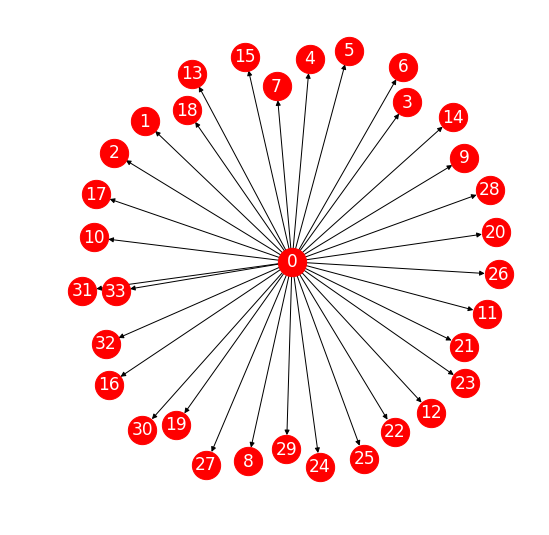

In [146]:
digraph = nx.DiGraph()

# The address of the sender, in this case the factory smart contract address.
edges_LHS = df_internal_txns.From[0:33]
# The addresses of the process instance smart contracts.
edges_RHS = df_internal_txns.ContractAddress[0:33]

edges_LHS = list(edges_LHS)
edges_RHS = list(edges_RHS)

edges = zip(edges_LHS, edges_RHS)
edges = list(edges)

digraph.add_edges_from(edges)
digraph_integer_labels = nx.convert_node_labels_to_integers(digraph, first_label=0)

draw_options = {
    'node_size': 800,
    'font_color': "white",
    'font_size': 17
}

plt.figure(figsize=(7,7))
nx.draw(digraph_integer_labels, with_labels=True, **draw_options)
plt.savefig("./process_instances_nx.png")

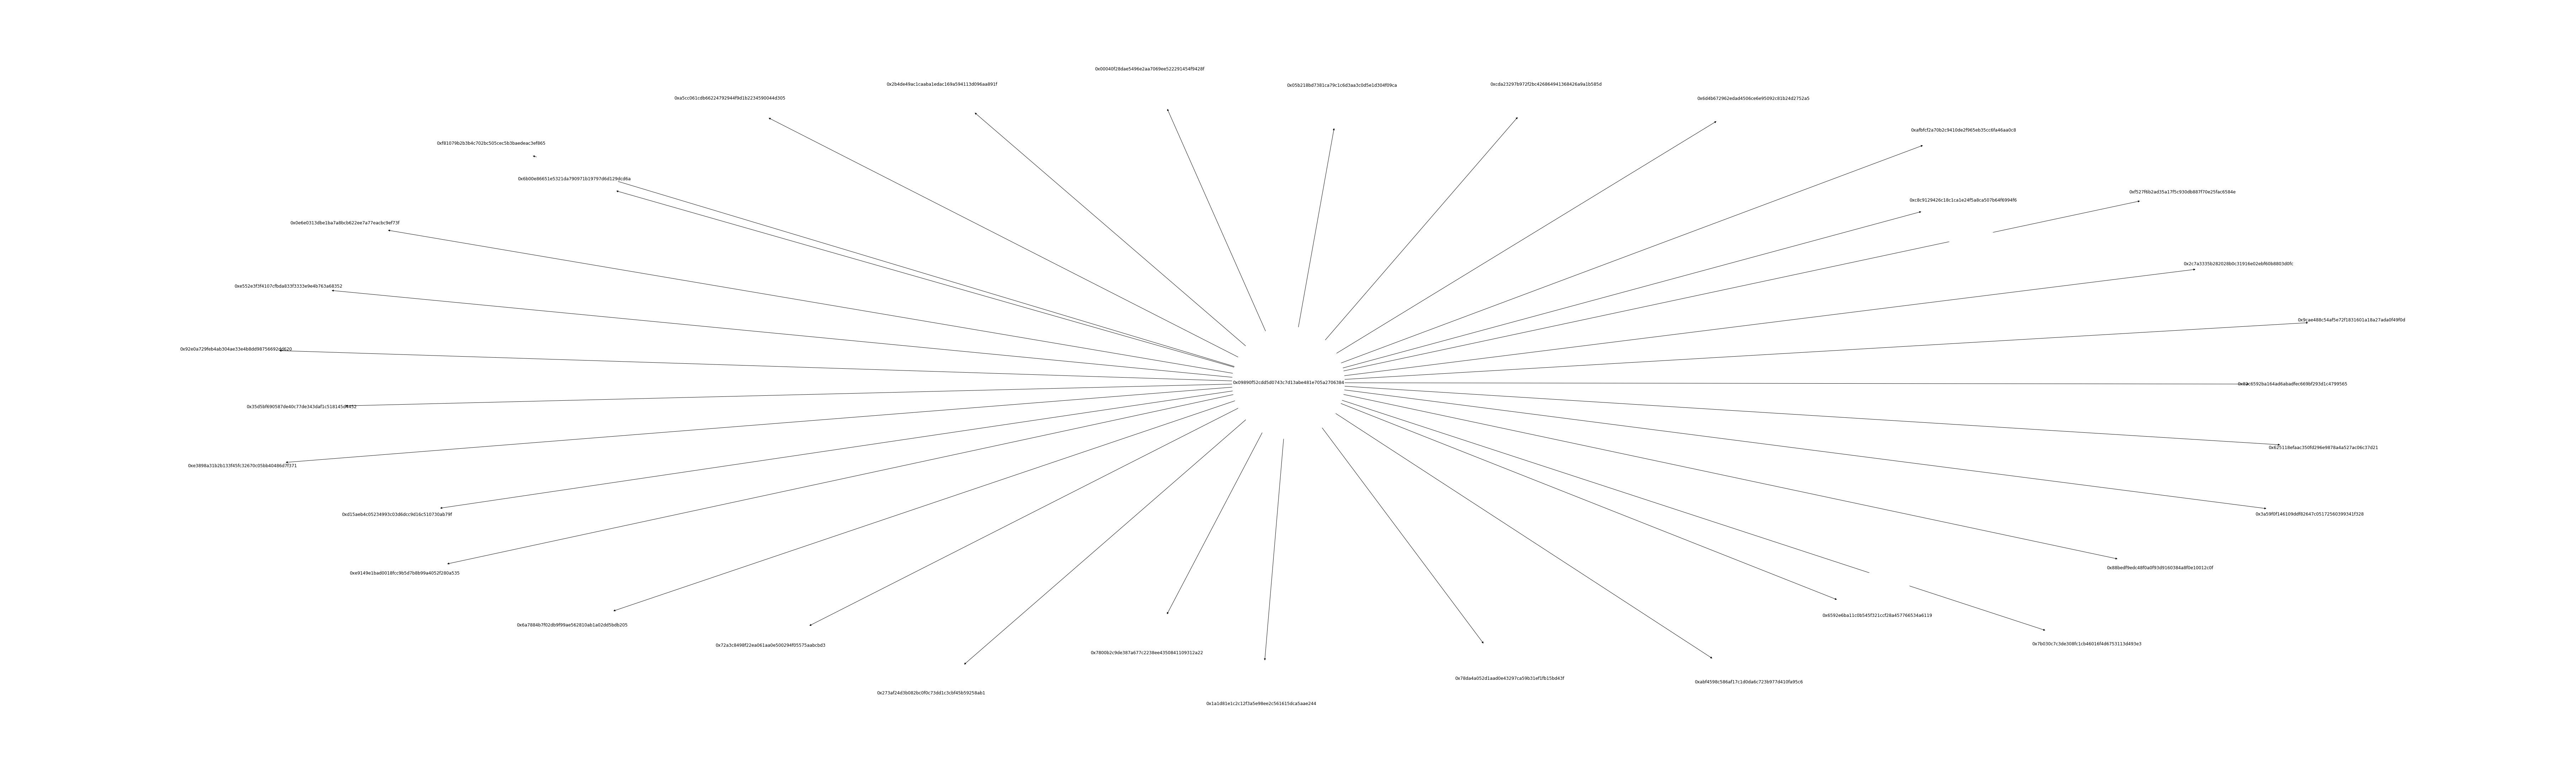

In [147]:
digraph = nx.DiGraph()

# The address of the sender, in this case the factory smart contract address.
edges_LHS = df_internal_txns.From[0:33]
# The addresses of the process instance smart contracts.
edges_RHS = df_internal_txns.ContractAddress[0:33]

edges_LHS = list(edges_LHS)
edges_RHS = list(edges_RHS)

edges = zip(edges_LHS, edges_RHS)
edges = list(edges)

digraph.add_edges_from(edges)

draw_options = {
    'node_color': "white"
}

instances_node_size = [60000] * 33
center_node_size = [100000]
node_sizes = []
node_sizes.extend(center_node_size)
node_sizes.extend(instances_node_size)

plt.figure(figsize=(100,30))
nx.draw(digraph, alpha=1, node_size=node_sizes, with_labels=True, **draw_options)

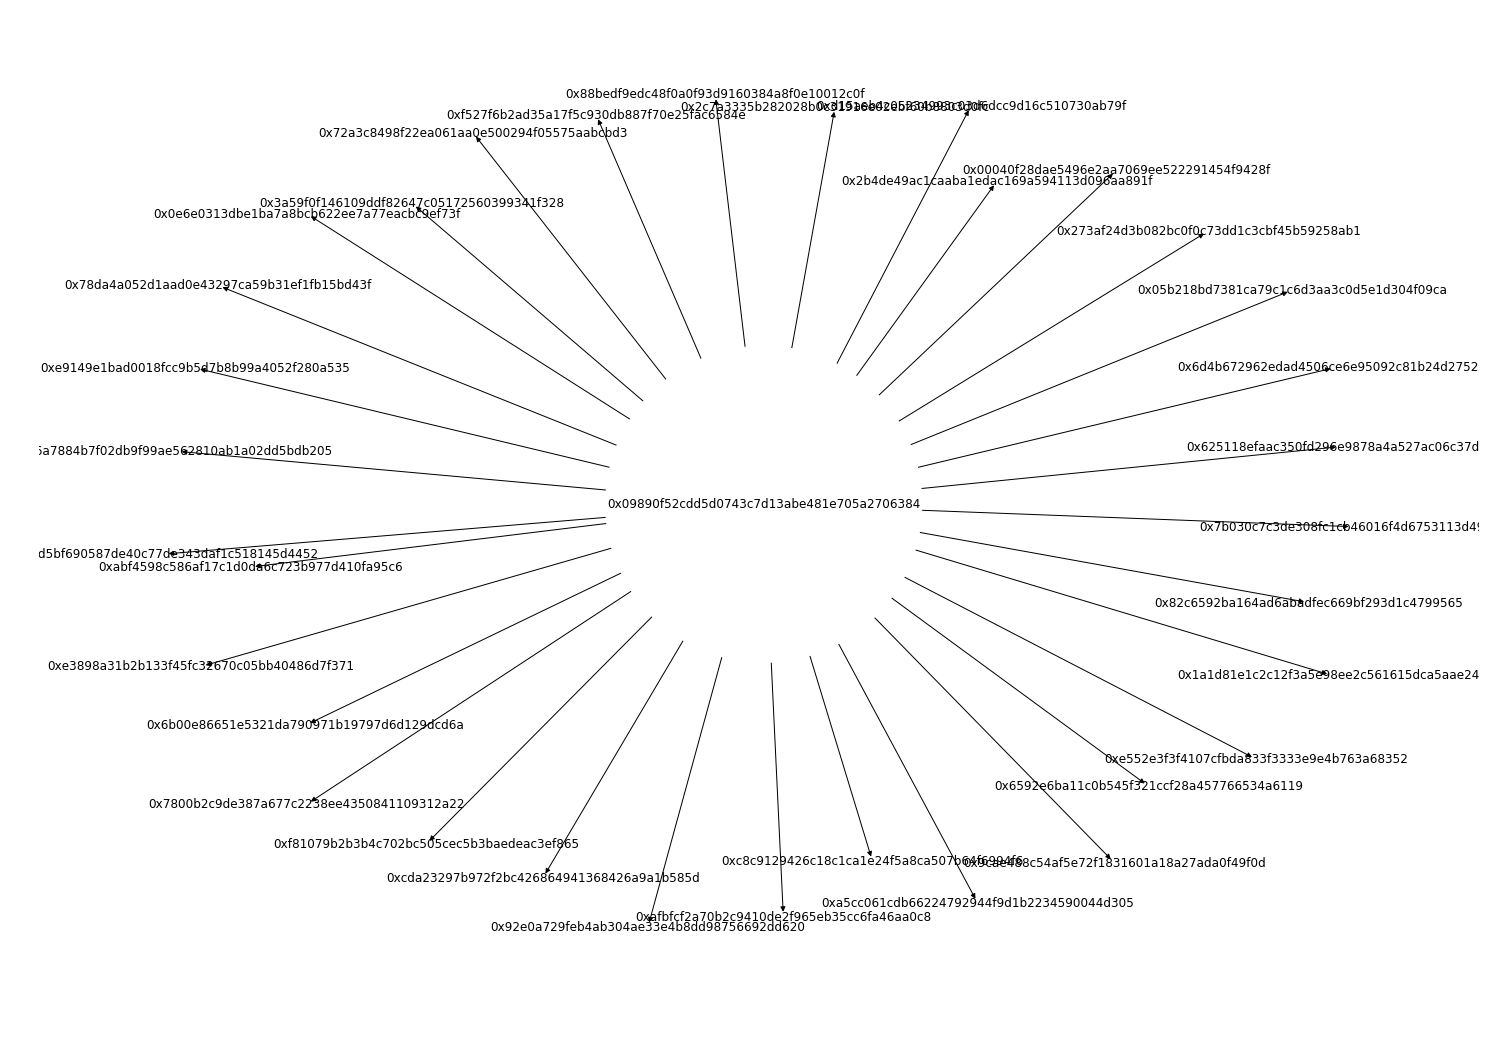

In [148]:
digraph = nx.DiGraph()

# The address of the sender, in this case the factory smart contract address.
edges_LHS = df_internal_txns.From[0:33]
# The addresses of the process instance smart contracts.
edges_RHS = df_internal_txns.ContractAddress[0:33]

edges_LHS = list(edges_LHS)
edges_RHS = list(edges_RHS)

edges = zip(edges_LHS, edges_RHS)
edges = list(edges)

digraph.add_edges_from(edges)

draw_options = {
    'node_color': "white",
    'font_size': 12
}

instances_node_size = [100] * 33
center_node_size = [100000]
node_sizes = []
node_sizes.extend(center_node_size)
node_sizes.extend(instances_node_size)

plt.figure(figsize=(20,14))
nx.draw(digraph, alpha=1, node_size=node_sizes, with_labels=True, **draw_options)

In [149]:
with PdfPages("./process_instances_nx.pdf") as pdf:
    pdf.savefig(plt)
    pdf.savefig()

NameError: name 'PdfPages' is not defined

In [ ]:
plt.savefig("./process_instances_nx.png")

In [ ]:
nx.nx_agraph.write_dot(digraph, "./proces_instances.dot")

## Transactions in CSV: From - To Graph

In [74]:
digraph = nx.DiGraph()

edges_LHS = list()
edges_RHS = list()

for idx_row, row in df_internal_txns.iterrows():
    edge_LHS = row["From"]
    edge_RHS = row["To"]
    
    edges_LHS.append(edge_LHS)
    edges_RHS.append(edge_RHS)
    
edges = zip(edges_LHS, edges_RHS)
edges = list(edges)

digraph.add_edges_from(edges)

nx.nx_agraph.write_dot(digraph, "./test.dot")

## Transactions in the Blocks: From - To Graph

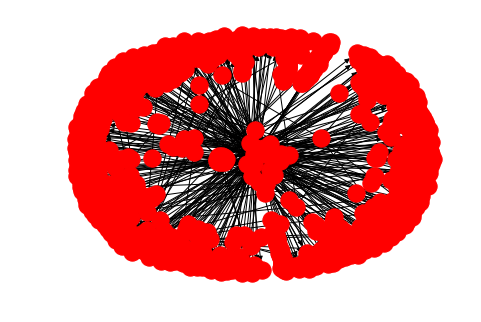

In [75]:
digraph = nx.DiGraph()

edges_LHS = list()
edges_RHS = list()


for idx_row, row in df_internal_txns.iterrows():
    block_no_dictionary = row["BlockNoDictionary"]
    block_transactions = block_no_dictionary["transactions"]
    
    for transaction in block_transactions:
        edge_LHS = transaction["from"]
        
        if "to" in transaction:
            edge_RHS = transaction["to"]
        else:
            edge_RHS = edge_LHS
            
        edges_LHS.append(edge_LHS)
        edges_RHS.append(edge_RHS)

        
edges = zip(edges_LHS, edges_RHS)
edges = list(edges)

digraph.add_edges_from(edges)

# Save graph to PNG.
nx.draw(digraph)
plt.savefig("./from_to.png")

In [76]:
# Save graph as DOT file.
nx.nx_agraph.write_dot(digraph, "./from_to.dot")

ValueError: too many values to unpack (expected 2)

In [77]:
len(edges_LHS)

4592

In [78]:
len(edges_RHS)

4592

In [79]:
len(edges)

4592

# Custom Functions

[Ethereum Homestead Documentation](http://ethdocs.org/en/latest/index.html)

[How to obtain all transaction of a contract?](https://ethereum.stackexchange.com/questions/16112/how-to-obtain-all-transaction-of-a-contract)

[How to get all the transactions made by a token address [duplicate]](https://ethereum.stackexchange.com/questions/36000/how-to-get-all-the-transactions-made-by-a-token-address)

[Common useful JavaScript snippets for geth](https://ethereum.stackexchange.com/questions/2531/common-useful-javascript-snippets-for-geth/3478#3478)
```javascript
function getTransactionsByAccount(myaccount, startBlockNumber, endBlockNumber) {
  if (endBlockNumber == null) {
    endBlockNumber = eth.blockNumber;
    console.log("Using endBlockNumber: " + endBlockNumber);
  }
  if (startBlockNumber == null) {
    startBlockNumber = endBlockNumber - 1000;
    console.log("Using startBlockNumber: " + startBlockNumber);
  }
  console.log("Searching for transactions to/from account \"" + myaccount + "\" within blocks "  + startBlockNumber + " and " + endBlockNumber);

  for (var i = startBlockNumber; i <= endBlockNumber; i++) {
    if (i % 1000 == 0) {
      console.log("Searching block " + i);
    }
    var block = eth.getBlock(i, true);
    if (block != null && block.transactions != null) {
      block.transactions.forEach( function(e) {
        if (myaccount == "*" || myaccount == e.from || myaccount == e.to) {
          console.log("  tx hash          : " + e.hash + "\n"
            + "   nonce           : " + e.nonce + "\n"
            + "   blockHash       : " + e.blockHash + "\n"
            + "   blockNumber     : " + e.blockNumber + "\n"
            + "   transactionIndex: " + e.transactionIndex + "\n"
            + "   from            : " + e.from + "\n" 
            + "   to              : " + e.to + "\n"
            + "   value           : " + e.value + "\n"
            + "   time            : " + block.timestamp + " " + new Date(block.timestamp * 1000).toGMTString() + "\n"
            + "   gasPrice        : " + e.gasPrice + "\n"
            + "   gas             : " + e.gas + "\n"
            + "   input           : " + e.input);
        }
      })
    }
  }
}
```

In [80]:
def get_all_transactions_for_contract_address(contract_address="0x09890f52cdd5d0743c7d13abe481e705a2706384", start_block_number=1196182, end_block_number=2440835):
    contract_address_transactions = list()
    
    print(f"Seacrhing for transactions to/from account {contract_address} within blocks {start_block_number} and {end_block_number}")
    
    for block_number in range(start_block_number, end_block_number):
        if block_number % 1000 == 0:
            print(f"Searching block {block_number}")
        
        block = w3.eth.getBlock(block_number)
        block_transactions = block["transactions"]
        
        for transaction in block_transactions:
          if transaction["from"] == contract_address:
              contract_address_transactions.append(transaction)
              continue
          
          if "to" in transaction and transaction["to"] == contract_address:
              contract_address_transactions.append(transaction)
          
    return contract_address_transactions

<a id="references"></a>
# References

<a id="weber_et_al"></a>
Weber, I., Xu, X., Riveret, R., Governatori, G., Ponomarev, A., & Mendling, J. (2016, September). Untrusted business process monitoring and execution using blockchain. In International Conference on Business Process Management (pp. 329-347). Springer, Cham.

<a id="di_ciccio_et_al"></a>
Di Ciccio, C., Cecconi, A., Mendling, J., Felix, D., Haas, D., Lilek, D., Riel, F., Rumpl, A. & Uhlig, P. (2018, July). Blockchain-based traceability of inter-organisational business processes. In International Symposium on Business Modeling and Software Design (pp. 56-68). Springer, Cham.

<a id="appendix"></a>
# Appendix
## Resources
[Ethereum/WiKi/Glossary](https://github.com/ethereum/wiki/wiki/Glossary)

[Blockchain/Vocabolary](https://bitcoin.org/en/vocabulary#bit)

[Etherscan - Explanation of Fields](https://etherscancom.freshdesk.com/support/solutions/articles/35000071628-how-to-explore-ethereum-addresses-on-etherscan-io)

[OpyenXes](http://pmuc.ing.puc.cl/tools/opyenxes/)

[OpyenXes - Create Random Log](https://github.com/opyenxes/OpyenXes/blob/master/example/Create_random_log.py)

[Search all smart contracts](https://ethereum.stackexchange.com/questions/40603/search-all-smart-contracts)

[UNMAINTAINED! Exporter for Ethereum blocks, transactions, ERC20 transfers, contracts, using Scrapy](https://github.com/blockchain-etl/ethereum-scraper)

[Online Solidity Decompiler](https://ethervm.io/decompile)

[*UNMAINTAINED* Decompiler and Security Analysis tool for Blockchain-based Ethereum Smart-Contracts](https://github.com/comaeio/porosity)

## Hosted Ethereum Miners
[EtherChain](https://www.etherchain.org/)

[EtherScan](https://etherscan.io/)

## Data Source
[Etherscan](https://etherscan.io/address/0x09890f52cdd5d0743c7d13abe481e705a2706384)